# Comparing rcrux and crabs databases with tax-credit

Example jupyter notebook for tax-credit.

## Generate datasets for each DB  
Based on [this notebook](https://github.com/caporaso-lab/tax-credit/blob/a1878884f62d60b8ba9dcc6c6ef4a9c8fdc0d917/ipynb/novel-taxa/dataset-generation.ipynb)

Run Jupyter notebook within the tax-credit folder.

In [1]:
!pwd

/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit


#### Novel-taxa reference data set generation


This section describes the preparation of the data sets necessary for "novel taxa" analysis. The goals of this step are:

1. Create a "clean" reference database that can be used for evaluation of "novel taxa" from phylum to species level.
2. Generate simulated amplicons and randomly subsample query sequences to use as "novel taxa"
3. Create modified sequence reference databases for taxonomic classification of "novel taxa" sequences  

In this first cell, we describe data set/database characteristics as a dictionary: dataset name is the key, with values reference sequence fasta, taxonomy, database name, forward primer sequence, reverse primer sequence, forward primer name, reverse primer name.

MODIFY these values to generate novel-taxa files on a new reference database

In [1]:
from tax_credit.framework_functions import \
    generate_simulated_datasets, distance_comparison, \
    test_cross_validated_sequences, \
    test_novel_taxa_datasets

from os.path import expandvars, join, splitext
import pandas as pd
import shutil

%matplotlib inline

### format databases for tax-credit

All databases need to have a fasta file and taxonomy file if you are subsampling taxa and sequences. Requirements:  
**fasta file**: no lower case sequences  
**taxonomy file**: Feature ID\tTaxon header (required for qiime2), no quotes, no repeated accession ids 

In [20]:
%%bash
#CRABS_ecoPCR
<data/ref_dbs/CRABS_ecoPCR/CRABS-Paper-ecoPCR_MiFish_DB.fasta tr '[:lower:]' '[:upper:]' > tmp.fa;
mv tmp.fa data/ref_dbs/CRABS_ecoPCR/CRABS-Paper-ecoPCR_MiFish_DB.fasta


In [7]:
%%bash
#CRABS_MiFish
echo -e "Feature ID\tTaxon">tmp.txt
sed 's/\"//g' data/ref_dbs/CRABS_MiFish/CRABS_MiFish_DB_taxonomy.txt >> tmp.txt
mv tmp.txt data/ref_dbs/CRABS_MiFish/CRABS_MiFish_DB_taxonomy.txt

In [48]:
%%bash
#rCRUX_12S
echo -e "Feature ID\tTaxon">tmp.txt
sed 's/\"//g' data/ref_dbs/rCRUX_12S/12S_derep_and_clean_taxonomy.txt >> tmp.txt
mv tmp.txt data/ref_dbs/rCRUX_12S/12S_derep_and_clean_taxonomy.txt

In [3]:
%%bash
#rCRUX_12S_seeds
echo -e "Feature ID\tTaxon">tmp.txt
sed 's/\"//g' data/ref_dbs/rCRUX_12S/12S/blast_seeds_output/12S_taxonomy.txt >> tmp.txt
mv tmp.txt data/ref_dbs/rCRUX_12S/12S_bs_taxonomy.txt

In [49]:
%%bash
#metacurator
echo -e "Feature ID\tTaxon">tmp.txt
sed 's/\"//g' data/ref_dbs/MetaCurator_MiFish/MetaCurator_MiFish_DB_taxonomy.txt >> tmp.txt
mv tmp.txt data/ref_dbs/MetaCurator_MiFish/MetaCurator_MiFish_DB_taxonomy.txt

In [50]:
%%bash
#12s_exp
echo -e "Feature ID\tTaxon">tmp.txt
sed 's/\"//g' data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_taxonomy.txt >> tmp.txt
mv tmp.txt data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_taxonomy.txt

In [4]:
%%bash
#12s_exp
echo -e "Feature ID\tTaxon">tmp.txt
sed 's/\"//g' data/ref_dbs/rCRUX_12S_exp/12S_expanded/blast_seeds_output/12S_expanded_taxonomy.txt >> tmp.txt
mv tmp.txt data/ref_dbs/rCRUX_12S_exp/12S_expanded_bs_taxonomy.txt

In [51]:
%%bash
#rescript
echo -e "Feature ID\tTaxon">tmp.txt
sed 's/\"//g' data/ref_dbs/RESCRIPt_MiFish/RESCRIPt_MiFish_DB_taxonomy.txt >> tmp.txt
mv tmp.txt data/ref_dbs/RESCRIPt_MiFish/RESCRIPt_MiFish_DB_taxonomy.txt

This dictionary has the different databases as keys, then the values are: ["Reference fasta file path", "Reference tax path", "Reference id", "Fwd primer", "Rev primer", "Fwd primer id", "Rev primer id"]

In [3]:
project_dir = expandvars("./")
data_dir = join(project_dir, "data")

# List databases as fasta/taxonomy file pairs
databases = {'CRABS_ecoPCR': ['data/ref_dbs/CRABS_ecoPCR/CRABS-Paper-ecoPCR_MiFish_DB.fasta', 
             'data/ref_dbs/CRABS_ecoPCR/CRABS-Paper-ecoPCR_MiFish_DB_taxonomy.txt',
             "CRABS_ecoPCR", "GCCGGTAAAACTCGTGCCAGC", "CATAGTGGGGTATCTAATCCCAGTTTG", "MiFishF", "MiFishR"],
             'CRABS_MiFish': ['data/ref_dbs/CRABS_MiFish/CRABS_MiFish_DB.fasta', 
             'data/ref_dbs/CRABS_MiFish/CRABS_MiFish_DB_taxonomy.txt',
             "CRABS_MiFish", "GCCGGTAAAACTCGTGCCAGC", "CATAGTGGGGTATCTAATCCCAGTTTG", "MiFishF", "MiFishR"],
            'MetaCurator_MiFish': ['data/ref_dbs/MetaCurator_MiFish/MetaCurator_MiFish_DB.fasta', 
             'data/ref_dbs/MetaCurator_MiFish/MetaCurator_MiFish_DB_taxonomy.txt',
             "MetaCurator_MiFish", "GCCGGTAAAACTCGTGCCAGC", "CATAGTGGGGTATCTAATCCCAGTTTG", "MiFishF", "MiFishR"],
            'rCRUX_12S': ['data/ref_dbs/rCRUX_12S/12S_derep_and_clean.fasta', 
             'data/ref_dbs/rCRUX_12S/12S_derep_and_clean_taxonomy.txt',
             "rCRUX_12S", "GCCGGTAAAACTCGTGCCAGC", "CATAGTGGGGTATCTAATCCCAGTTTG", "MiFishF", "MiFishR"],
             'rCRUX_12S_exp': ['data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean.fasta', 
             'data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_taxonomy.txt',
             "rCRUX_12S_exp", "GCCGGTAAAACTCGTGCCAGC", "CATAGTGGGGTATCTAATCCCAGTTTG", "MiFishF", "MiFishR"],
             'RESCRIPt_MiFish': ['data/ref_dbs/RESCRIPt_MiFish/RESCRIPt_MiFish_DB.fasta', 
             'data/ref_dbs/RESCRIPt_MiFish/RESCRIPt_MiFish_DB_taxonomy.txt',
             "RESCRIPt_MiFish", "GCCGGTAAAACTCGTGCCAGC", "CATAGTGGGGTATCTAATCCCAGTTTG", "MiFishF", "MiFishR"],
             }

In [42]:
# Arrange data set / database info in data frame
simulated_community_definitions = pd.DataFrame.from_dict(databases, orient="index")
simulated_community_definitions.columns = ["Reference file path", "Reference tax path", "Reference id", 
                                           "Fwd primer", "Rev primer", "Fwd primer id", "Rev primer id"]
simulated_community_definitions

,Reference file path,Reference tax path,Reference id,Fwd primer,Rev primer,Fwd primer id,Rev primer id
CRABS_ecoPCR,data/ref_dbs/CRABS_ecoPCR/CRABS-Paper-ecoPCR_M...,data/ref_dbs/CRABS_ecoPCR/CRABS-Paper-ecoPCR_M...,CRABS_ecoPCR,GCCGGTAAAACTCGTGCCAGC,CATAGTGGGGTATCTAATCCCAGTTTG,MiFishF,MiFishR
CRABS_MiFish,data/ref_dbs/CRABS_MiFish/CRABS_MiFish_DB.fasta,data/ref_dbs/CRABS_MiFish/CRABS_MiFish_DB_taxo...,CRABS_MiFish,GCCGGTAAAACTCGTGCCAGC,CATAGTGGGGTATCTAATCCCAGTTTG,MiFishF,MiFishR
MetaCurator_MiFish,data/ref_dbs/MetaCurator_MiFish/MetaCurator_Mi...,data/ref_dbs/MetaCurator_MiFish/MetaCurator_Mi...,MetaCurator_MiFish,GCCGGTAAAACTCGTGCCAGC,CATAGTGGGGTATCTAATCCCAGTTTG,MiFishF,MiFishR
rCRUX_12S,data/ref_dbs/rCRUX_12S/12S_derep_and_clean.fasta,data/ref_dbs/rCRUX_12S/12S_derep_and_clean_tax...,rCRUX_12S,GCCGGTAAAACTCGTGCCAGC,CATAGTGGGGTATCTAATCCCAGTTTG,MiFishF,MiFishR
rCRUX_12S_exp,data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_...,data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_...,rCRUX_12S_exp,GCCGGTAAAACTCGTGCCAGC,CATAGTGGGGTATCTAATCCCAGTTTG,MiFishF,MiFishR
RESCRIPt_MiFish,data/ref_dbs/RESCRIPt_MiFish/RESCRIPt_MiFish_D...,data/ref_dbs/RESCRIPt_MiFish/RESCRIPt_MiFish_D...,RESCRIPt_MiFish,GCCGGTAAAACTCGTGCCAGC,CATAGTGGGGTATCTAATCCCAGTTTG,MiFishF,MiFishR


In [45]:
simulated_community_definitions.index

Index(['CRABS_ecoPCR', 'CRABS_MiFish', 'MetaCurator_MiFish', 'rCRUX_12S',
       'rCRUX_12S_exp', 'RESCRIPt_MiFish'],
      dtype='object')

This code is to loop through databases and prepare N simulated datasets for each database by subsampling taxa and sequences. First, it removes taxa with too many NAs, then it does an in-silico PCR based on the primers, then filters by the provioded minimum read length. Ideally the whole code can be run like this:  

```
read_length = 250
iterations = 10
min_read_length = 140
generate_simulated_datasets(simulated_community_definitions, data_dir, 
                            read_length, iterations, min_read_length=min_read_length,
                            levelrange=range(6, 1, -1), force=True)
```

However, rcrux databases and others do not have the primer sequences anymore, and so this function gets wonky. The code below basically just copies the cleaned up fasta files over the empty file with the "trimmed" sequences.

In [52]:
read_length = 250
iterations = 10
min_read_length = 140
for i in simulated_community_definitions.index:
    print("1st pass of " + i+": ")
    try:
        generate_simulated_datasets(simulated_community_definitions.loc[[i]], data_dir, 
                            read_length, iterations, min_read_length=min_read_length,
                            levelrange=range(6, 2, -1), force=True)
    except:
        continue

for i in simulated_community_definitions.index:
    # copy our cleaned ref DB to the trimmed file, since they are already trimmed
    data = simulated_community_definitions.loc[[i]].squeeze()
    base, ext = splitext(data['Reference file path'])
    trimmed_reads = join('{0}_clean_{1}-{2}_trim250{3}'.format(
        base, data['Fwd primer id'], data['Rev primer id'], ext))
    clean_fasta = join('{0}_clean{1}'.format(
        base, ext))
    shutil.copyfile(clean_fasta, trimmed_reads)
    print("Copy to trimmed reads, " + i+": ")

for i in simulated_community_definitions.index:
    # now rerun build datasets, using the trimmed files
    print("2nd pass of" + i+": ")
    generate_simulated_datasets(simulated_community_definitions.loc[[i]], data_dir, 
                            read_length, iterations, min_read_length=min_read_length,
                            levelrange=range(6, 2, -1), force=False)


1st pass of CRABS_ecoPCR: 
1st pass of CRABS_MiFish: 
1st pass of MetaCurator_MiFish: 
1st pass of rCRUX_12S: 
rCRUX_12S Sequence Counts
Raw Fasta:            33003.0
Clean Fasta:          33002.0
Simulated Reads:      0.0
rCRUX_12S: generating 10 folds on 1 strata


/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/skbio/io/registry.py:547: FormatIdentificationWarning: <_io.BufferedReader name='./data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.fasta'> does not look like a fasta file
  warn("%r does not look like a %s file"


1st pass of rCRUX_12S_exp: 
rCRUX_12S_exp Sequence Counts
Raw Fasta:            33117.0
Clean Fasta:          33116.0
Simulated Reads:      0.0
rCRUX_12S_exp: generating 10 folds on 1 strata


/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/skbio/io/registry.py:547: FormatIdentificationWarning: <_io.BufferedReader name='./data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_clean_MiFishF-MiFishR_trim250.fasta'> does not look like a fasta file
  warn("%r does not look like a %s file"


1st pass of RESCRIPt_MiFish: 
Copy to trimmed reads, CRABS_ecoPCR: 
Copy to trimmed reads, CRABS_MiFish: 
Copy to trimmed reads, MetaCurator_MiFish: 
Copy to trimmed reads, rCRUX_12S: 
Copy to trimmed reads, rCRUX_12S_exp: 
Copy to trimmed reads, RESCRIPt_MiFish: 
2nd pass ofCRABS_ecoPCR: 
simulated reads and amplicons exist: skipping extraction
CRABS_ecoPCR Sequence Counts
Raw Fasta:            15301.0
Clean Fasta:          15300.0
Simulated Reads:      15300.0
CRABS_ecoPCR: generating 10 folds on 566 strata


/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a futu

2nd pass ofCRABS_MiFish: 
simulated reads and amplicons exist: skipping extraction
CRABS_MiFish Sequence Counts
Raw Fasta:            28349.0
Clean Fasta:          28348.0
Simulated Reads:      28348.0
CRABS_MiFish: generating 10 folds on 1031 strata


/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a futu

2nd pass ofMetaCurator_MiFish: 
simulated reads and amplicons exist: skipping extraction
MetaCurator_MiFish Sequence Counts
Raw Fasta:            27653.0
Clean Fasta:          27652.0
Simulated Reads:      27652.0
MetaCurator_MiFish: generating 10 folds on 987 strata


/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a futu

2nd pass ofrCRUX_12S: 
simulated reads and amplicons exist: skipping extraction
rCRUX_12S Sequence Counts
Raw Fasta:            33003.0
Clean Fasta:          33002.0
Simulated Reads:      33002.0
rCRUX_12S: generating 10 folds on 1218 strata


/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a futu

2nd pass ofrCRUX_12S_exp: 
simulated reads and amplicons exist: skipping extraction
rCRUX_12S_exp Sequence Counts
Raw Fasta:            33117.0
Clean Fasta:          33116.0
Simulated Reads:      33116.0
rCRUX_12S_exp: generating 10 folds on 1225 strata


/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a futu

2nd pass ofRESCRIPt_MiFish: 
simulated reads and amplicons exist: skipping extraction
RESCRIPt_MiFish Sequence Counts
Raw Fasta:            17983.0
Clean Fasta:          17982.0
Simulated Reads:      17982.0
RESCRIPt_MiFish: generating 10 folds on 673 strata


/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_series = taxonomy_series[train]
/space/home/cns.local/katherine.silliman/databases/rcrux-testing/tax-credit/tax_credit/framework_functions.py:452: FutureWarning: Passing a set as an indexer is deprecated and will raise in a futu

## Taxonomic assignment of cross-validated generated data  
Based on this [notebook](https://github.com/caporaso-lab/tax-credit/blob/a1878884f62d60b8ba9dcc6c6ef4a9c8fdc0d917/ipynb/novel-taxa/taxonomy-assignment.ipynb)

**using python to sweep over methods and parameters**

In [35]:
from os import system
import subprocess
from os.path import join, expandvars 
from joblib import Parallel, delayed
from glob import glob
from tax_credit.framework_functions import (recall_novel_taxa_dirs,
                                            parameter_sweep,
                                            move_results_to_repository)

In [36]:
analysis_name= "cross-validated"

results_dir = 'cross-validated-tmp'

#### preparing dataset sweep

First, we're going to define the data sets that we'll sweep over. The "cross-validated" simulated reads that we use here are subsets of reference sequence databases generated duing the novel-taxa analysis. We re-use these data sets here for the purposes of having cross-validated data subsets. As the cross-validated dataset names depend on how the database generation notebook was executed, we must define the variables used to create these datasets. If you modified any variables in that notebook, set these same variables below. If you did not, then do not modify.

recall_novel_taxa_dirs() generates a list of dataset_reference_combinations and a dictionary of reference_dbs mapped to each dataset, which we feed to parameter_sweep below.

In [4]:
iterations = 10
data_dir = join(project_dir, "data", analysis_name)
# databases is a list of names given as dictionary keys in the second
# cell of the database generation notebook. Just list the names here.
databases = ['CRABS_ecoPCR', 'CRABS_MiFish', 'MetaCurator_MiFish', 'rCRUX_12S',
       'rCRUX_12S_exp', 'RESCRIPt_MiFish']

# Generate a list of input directories
(dataset_reference_combinations, reference_dbs) = recall_novel_taxa_dirs(\
    data_dir, databases, iterations, ref_seqs='ref_seqs.qza',
    ref_taxa='ref_taxa.qza', max_level=6, min_level=5, multilevel=False)

In [5]:
dataset_reference_combinations

[('CRABS_ecoPCR-iter0', 'CRABS_ecoPCR-iter0'),
 ('CRABS_ecoPCR-iter1', 'CRABS_ecoPCR-iter1'),
 ('CRABS_ecoPCR-iter2', 'CRABS_ecoPCR-iter2'),
 ('CRABS_ecoPCR-iter3', 'CRABS_ecoPCR-iter3'),
 ('CRABS_ecoPCR-iter4', 'CRABS_ecoPCR-iter4'),
 ('CRABS_ecoPCR-iter5', 'CRABS_ecoPCR-iter5'),
 ('CRABS_ecoPCR-iter6', 'CRABS_ecoPCR-iter6'),
 ('CRABS_ecoPCR-iter7', 'CRABS_ecoPCR-iter7'),
 ('CRABS_ecoPCR-iter8', 'CRABS_ecoPCR-iter8'),
 ('CRABS_ecoPCR-iter9', 'CRABS_ecoPCR-iter9'),
 ('CRABS_MiFish-iter0', 'CRABS_MiFish-iter0'),
 ('CRABS_MiFish-iter1', 'CRABS_MiFish-iter1'),
 ('CRABS_MiFish-iter2', 'CRABS_MiFish-iter2'),
 ('CRABS_MiFish-iter3', 'CRABS_MiFish-iter3'),
 ('CRABS_MiFish-iter4', 'CRABS_MiFish-iter4'),
 ('CRABS_MiFish-iter5', 'CRABS_MiFish-iter5'),
 ('CRABS_MiFish-iter6', 'CRABS_MiFish-iter6'),
 ('CRABS_MiFish-iter7', 'CRABS_MiFish-iter7'),
 ('CRABS_MiFish-iter8', 'CRABS_MiFish-iter8'),
 ('CRABS_MiFish-iter9', 'CRABS_MiFish-iter9'),
 ('MetaCurator_MiFish-iter0', 'MetaCurator_MiFish-iter0'),
 

In [6]:
reference_dbs

{'CRABS_ecoPCR-iter0': ('./data/cross-validated/CRABS_ecoPCR-iter0/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter0/ref_taxa.qza'),
 'CRABS_ecoPCR-iter1': ('./data/cross-validated/CRABS_ecoPCR-iter1/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter1/ref_taxa.qza'),
 'CRABS_ecoPCR-iter2': ('./data/cross-validated/CRABS_ecoPCR-iter2/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter2/ref_taxa.qza'),
 'CRABS_ecoPCR-iter3': ('./data/cross-validated/CRABS_ecoPCR-iter3/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter3/ref_taxa.qza'),
 'CRABS_ecoPCR-iter4': ('./data/cross-validated/CRABS_ecoPCR-iter4/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter4/ref_taxa.qza'),
 'CRABS_ecoPCR-iter5': ('./data/cross-validated/CRABS_ecoPCR-iter5/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter5/ref_taxa.qza'),
 'CRABS_ecoPCR-iter6': ('./data/cross-validated/CRABS_ecoPCR-iter6/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter6/ref_taxa.qza'),

#### Prepare method/parameter combinations

Here we provide an example of taxonomy assignment using classifiers executed on the command line. To accomplish this, we must first convert commands to a string, which we then pass to bash for execution. we must also activate a separate environment in which QIIME2 has been installed if not installed in the tax-credit environment. If any environmental variables need to be set (in this example, the RDP_JAR_PATH), we must also source the .bashrc file.

Now enter the template of the command to sweep, and generate a list of commands with parameter_sweep().

Fields must adhere to following format:

                  {0} = output directory
                  {1} = input data
                  {2} = output destination
                  {3} = reference taxonomy
                  {4} = method name
                  {5} = other parameters

#### naive-bayes

This code generates a classifier for each of the 10 subsamples of each database. It could be tweaked to just use an existing classifier. 

[fit-classifier-naive-bayes manual](https://docs.qiime2.org/2023.2/plugins/available/feature-classifier/fit-classifier-naive-bayes/)  
- [kmer length setting](https://forum.qiime2.org/t/how-to-set-up-a-high-recall-classifier-change-k-mer-length/5750/13)

[feature-classifier classify-sklearn manual](https://docs.qiime2.org/2023.2/plugins/available/feature-classifier/classify-sklearn/)

In [ ]:
method_parameters_combinations = {
    'naive-bayes' : {'p-feat-ext--ngram-range': ['[7,7]'],
                     'p-classify--alpha': [0.001]}
}

# example if you need to activate qiime2 environment
# command_template = 'bash -c "source activate qiime2-2023.5;...."'


command_template = ('mkdir -p "{0}"; '
                    'qiime feature-classifier fit-classifier-naive-bayes --o-classifier '
                    '"{0}/classifier.qza" --i-reference-reads {2} --i-reference-taxonomy {3} {5}; '
                    'qiime feature-classifier classify-sklearn --p-n-jobs 5 '
    '--o-classification "{0}/rep_seqs_tax_assignments.qza" '
    '--i-classifier "{0}/classifier.qza" '
    '--i-reads {1} --p-confidence 0.7; '
    'qiime tools export --input-path "{0}/rep_seqs_tax_assignments.qza" --output-path "{0}/taxonomy.tsv" '
    '--output-format TSVTaxonomyFormat; '
    'mv "{0}/taxonomy.tsv" "{0}/query_tax_assignments.txt"; ')                  

(dataset_reference_combinations, reference_dbs) = recall_novel_taxa_dirs(\
    data_dir, databases, iterations, ref_seqs='ref_seqs.qza',
    ref_taxa='ref_taxa.qza', max_level=6, min_level=5, multilevel=False)

commands = parameter_sweep(data_dir, results_dir, reference_dbs,
                           dataset_reference_combinations,
                           method_parameters_combinations, command_template,
                           infile='query.qza', output_name='rep_seqs_tax_assignments.qza')

In [21]:
method_parameters_combinations = {
    'naive-bayes' : {'p-feat-ext--ngram-range': ['[7,7]'],
                     'p-classify--alpha': [0.001]}
}

command_template = ('mkdir -p "{0}"; '
                    'qiime feature-classifier fit-classifier-naive-bayes --o-classifier '
                    '"{0}/classifier.qza" --i-reference-reads {2} --i-reference-taxonomy {3} {5}; '
                    'qiime feature-classifier classify-sklearn --p-n-jobs 5 '
    '--o-classification "{0}/rep_seqs_tax_assignments.qza" '
    '--i-classifier "{0}/classifier.qza" '
    '--i-reads {1} --p-confidence 0.7; '
    'qiime tools export --input-path "{0}/rep_seqs_tax_assignments.qza" --output-path "{0}/taxonomy.tsv" '
    '--output-format TSVTaxonomyFormat; '
    'mv "{0}/taxonomy.tsv" "{0}/query_tax_assignments.txt"; ')                  


commands = parameter_sweep(data_dir, results_dir, reference_dbs,
                           dataset_reference_combinations,
                           method_parameters_combinations, command_template,
                           infile='query.qza', output_name='rep_seqs_tax_assignments.qza')

In [22]:
# sanity check, do commands look ok?
print(len(commands))
print(commands[0])

60
mkdir -p "cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]"; qiime feature-classifier fit-classifier-naive-bayes --o-classifier "cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]/classifier.qza" --i-reference-reads ./data/cross-validated/CRABS_ecoPCR-iter0/ref_seqs.qza --i-reference-taxonomy ./data/cross-validated/CRABS_ecoPCR-iter0/ref_taxa.qza --p-classify--alpha 0.001 --p-feat-ext--ngram-range [7,7]; qiime feature-classifier classify-sklearn --p-n-jobs 5 --o-classification "cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza" --i-classifier "cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]/classifier.qza" --i-reads ./data/cross-validated/CRABS_ecoPCR-iter0/query.qza --p-confidence 0.7; qiime tools export --input-path "cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qz

In [19]:
#testing
subprocess.call(commands[0],shell=True)

Saved TaxonomicClassifier to: cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]/classifier.qza
Saved FeatureData[Taxonomy] to: cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Exported cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza as TSVTaxonomyFormat to file cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]/taxonomy.tsv


0

In [23]:
Parallel(n_jobs=5)(delayed(system)(command) for command in commands);

Saved TaxonomicClassifier to: cross-validated-tmp/CRABS_ecoPCR-iter1/CRABS_ecoPCR-iter1/naive-bayes/0.001:[7,7]/classifier.qza
Saved TaxonomicClassifier to: cross-validated-tmp/CRABS_ecoPCR-iter3/CRABS_ecoPCR-iter3/naive-bayes/0.001:[7,7]/classifier.qza
Saved TaxonomicClassifier to: cross-validated-tmp/CRABS_ecoPCR-iter2/CRABS_ecoPCR-iter2/naive-bayes/0.001:[7,7]/classifier.qza
Saved TaxonomicClassifier to: cross-validated-tmp/CRABS_ecoPCR-iter0/CRABS_ecoPCR-iter0/naive-bayes/0.001:[7,7]/classifier.qza
Saved TaxonomicClassifier to: cross-validated-tmp/CRABS_ecoPCR-iter4/CRABS_ecoPCR-iter4/naive-bayes/0.001:[7,7]/classifier.qza
Saved FeatureData[Taxonomy] to: cross-validated-tmp/CRABS_ecoPCR-iter3/CRABS_ecoPCR-iter3/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Saved FeatureData[Taxonomy] to: cross-validated-tmp/CRABS_ecoPCR-iter1/CRABS_ecoPCR-iter1/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Saved FeatureData[Taxonomy] to: cross-validated-tmp/CRABS_ecoPCR-iter2/CRABS_ec

## Evaluate cross-validated results

Based on this [notebook](https://github.com/caporaso-lab/tax-credit/blob/a1878884f62d60b8ba9dcc6c6ef4a9c8fdc0d917/ipynb/cross-validated/evaluate-classification.ipynb).   

This section demonstrates how to evaluate classification accuracy of "cross-validated" simulated communities. Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy are different from those used for mock.

The key measure here is rate of match vs. overclassification, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:

- Match vs. overclassification rate  
    - Match: exact match at level L  
    - underclassification: lineage assignment is correct, but shorter than expected (e.g., not to species level)  
    - misclassification: incorrect assignment  
    
    
Where L = taxonomic level being tested  




In [24]:
#Move results from the temp folder to the final folder (only necessary if you need to because you reran some analyses)
comp_results_dir = join(project_dir, "data", "self-results", analysis_name)
method_dirs = glob(join(results_dir, '*', '*', '*', '*'))
move_results_to_repository(method_dirs, comp_results_dir)

In [7]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation,
                                            extract_per_level_accuracy)
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset,
                                           boxplot_from_data_frame)

import seaborn as sns
import pandas as pd
from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 200)

In [9]:
%matplotlib inline

In [157]:
project_dir = expandvars("./")
analysis_name = "cross-validated"
computed_results_dir = join(project_dir, "data", "self-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(computed_results_dir, 'evaluate_classification_summary_CV-self.csv')

results_dirs = glob(join(computed_results_dir, '*', '*', '*', '*'))

# we can save plots in this directory
outdir = expandvars("./plots/")

In [158]:
force = False
if force or not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir,
                                                            summary_fp, test_type='cross-validated')
else:
    accuracy_results = pd.read_csv(summary_fp,index_col=0)

In [159]:
accuracy_results.head()

,Dataset,level,iteration,Method,Parameters,match_ratio,overclassification_ratio,underclassification_ratio,misclassification_ratio,mismatch_level_list,Precision,Recall,F-measure
0,CRABS_ecoPCR,6,0,naive-bayes,"0.001:[7,7]",0.488889,0.275817,0.138562,0.096732,"[0, 1, 8, 45, 58, 290, 556, 572]","[0, 0.9993464052287582, 0.9993429697766097, 0.9952830188679245, 0.9786795048143053, 0.8743608473338204, 0.56752655538695]","[0, 0.9993464052287582, 0.9941176470588236, 0.965359477124183, 0.9300653594771242, 0.7823529411764706, 0.4888888888888889]","[0, 0.9993464052287582, 0.9967234600262124, 0.9800928998009291, 0.9537533512064343, 0.8258020006898931, 0.5252808988764045]"
1,CRABS_ecoPCR,6,1,naive-bayes,"0.001:[7,7]",0.486275,0.275163,0.134641,0.103922,"[0, 0, 6, 39, 58, 281, 574, 572]","[0, 1.0, 0.999344262295082, 0.9973190348525469, 0.9794941900205059, 0.8715925394548063, 0.5619335347432024]","[0, 1.0, 0.996078431372549, 0.9725490196078431, 0.9366013071895425, 0.7941176470588235, 0.48627450980392156]","[0, 1.0, 0.9977086743044191, 0.984778292521509, 0.9575676578683595, 0.8310533515731874, 0.521373510861948]"
2,CRABS_ecoPCR,6,3,naive-bayes,"0.001:[7,7]",0.490850,0.264706,0.130719,0.113725,"[0, 1, 7, 29, 58, 293, 541, 601]","[0, 1.0, 1.0, 0.9959973315543695, 0.9789115646258504, 0.855, 0.5646616541353383]","[0, 0.9993464052287582, 0.9947712418300654, 0.9758169934640523, 0.9405228758169935, 0.7823529411764706, 0.49084967320261436]","[0, 0.9996730957829356, 0.9973787680209699, 0.9858038956751403, 0.9593333333333333, 0.8170648464163823, 0.5251748251748253]"
3,CRABS_ecoPCR,6,2,naive-bayes,"0.001:[7,7]",0.483660,0.285621,0.137255,0.093464,"[0, 0, 11, 45, 67, 250, 576, 581]","[0, 1.0, 0.9980289093298291, 0.9946018893387314, 0.9738292011019284, 0.881159420289855, 0.5606060606060606]","[0, 1.0, 0.9928104575163399, 0.9633986928104575, 0.9241830065359478, 0.7947712418300653, 0.48366013071895425]","[0, 1.0, 0.9954128440366973, 0.9787516600265604, 0.948356807511737, 0.8357388316151202, 0.519298245614035]"
4,CRABS_ecoPCR,6,4,naive-bayes,"0.001:[7,7]",0.488889,0.286928,0.120915,0.103268,"[0, 1, 4, 38, 62, 275, 581, 569]","[0, 0.9993464052287582, 0.9986902423051736, 0.9913333333333333, 0.9721467391304348, 0.8567375886524823, 0.5561338289962825]","[0, 0.9993464052287582, 0.9967320261437909, 0.9718954248366013, 0.9352941176470588, 0.7895424836601307, 0.4888888888888889]","[0, 0.9993464052287582, 0.9977101733725875, 0.9815181518151814, 0.9533644237175217, 0.8217687074829932, 0.5203478260869564]"


### Plot results

Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_palette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).  

**match_ratio** = proportion of correct matches.

**𝐏𝐫𝐞𝐜𝐢𝐬𝐢𝐨𝐧** = true positives /(true positives + false positives  
**𝐑𝐞𝐜𝐚𝐥𝐥** = true positives /(true positives + false negatives)  
**F1**=(2∗ precision ∗ recall)/(precision + recall)  
For precision, a score of 1 indicates only mock community taxa were detected, whereas lower scores indicate detection of additional taxa (e.g., false positives). For recall, a score of 1 indicates all taxa in the mock community were detected, whereas a lower score indicates some taxa were not detected.
The F1 score is the harmonic mean of precision and recall (both measures are weighted equally),

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [47]:
color_palette={
    'CRABS_ecoPCR': 'coral', 'CRABS_MiFish': 'green',
    'MetaCurator_MiFish': 'firebrick', 'rCRUX_12S': 'dodgerblue',
    'rCRUX_12S_exp': 'blue', 'RESCRIPt_MiFish': 'orange',
}

In [48]:
color_palette_method={
    'blast+': 'coral', 'naive-bayes': 'dodgerblue',
    'vsearch': 'firebrick'
}


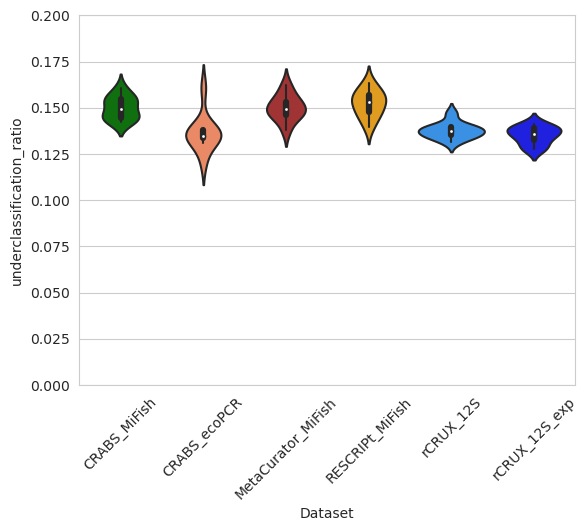

In [14]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="underclassification_ratio",
                            color_palette=color_palette,
                            y_min= 0,
                            y_max = 0.2
                           )

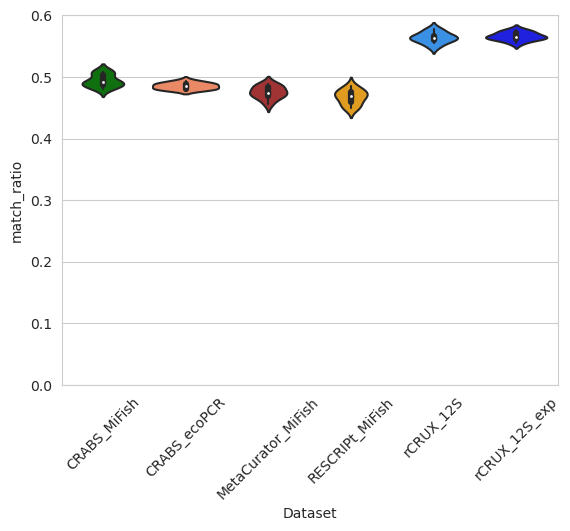

In [56]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="match_ratio",
                            color_palette=color_palette,
                            #y_min= 0,
                            y_max = 0.6
                           )

In [57]:
b.figure.savefig(join(outdir, 'cross-val-match_ratio-violinplots.pdf'))

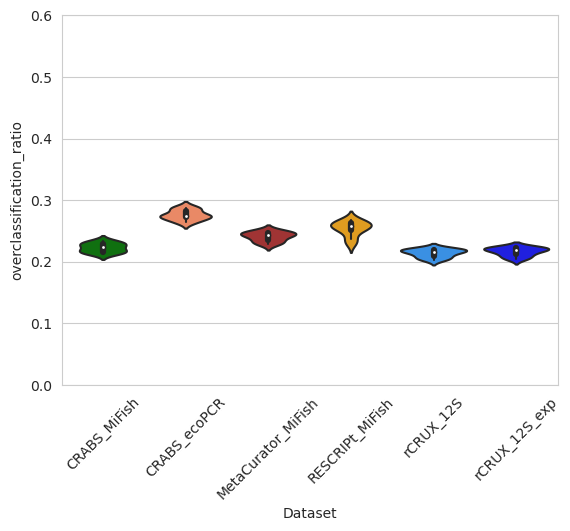

In [52]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="overclassification_ratio",
                            color_palette=color_palette,
                            #y_min= 0,
                            y_max = 0.6
                           )

In [55]:
b.figure.savefig(join(outdir, 'cross-val-overclassification_ratio-violinplots.pdf'))

In [160]:
level_results = extract_per_level_accuracy(accuracy_results)
y_vars = ['Precision', 'Recall', 'F-measure', 'match_ratio']

In [161]:
level_results.head()

,Dataset,level,iteration,Method,Parameters,Precision,Recall,F-measure,match_ratio
0,CRABS_ecoPCR,1,0,naive-bayes,"0.001:[7,7]",0.999346,0.999346,0.999346,0.999346
1,CRABS_ecoPCR,2,0,naive-bayes,"0.001:[7,7]",0.999343,0.994118,0.996723,0.994118
2,CRABS_ecoPCR,3,0,naive-bayes,"0.001:[7,7]",0.995283,0.965359,0.980093,0.964706
3,CRABS_ecoPCR,4,0,naive-bayes,"0.001:[7,7]",0.978680,0.930065,0.953753,0.926797
4,CRABS_ecoPCR,5,0,naive-bayes,"0.001:[7,7]",0.874361,0.782353,0.825802,0.737255


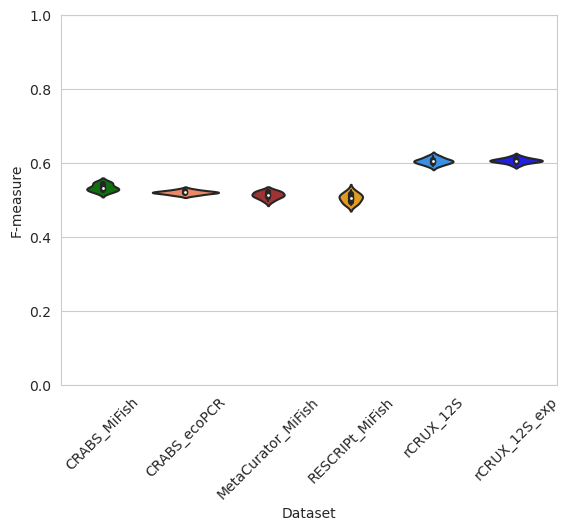

In [66]:
b = boxplot_from_data_frame(level_results[level_results['level']==6],group_by="Dataset",
                            metric="F-measure",
                            color_palette=color_palette,
                            #y_min= 0,
                           )

In [67]:
b.figure.savefig(join(outdir, 'cross-val-Fmeasure-level6-violinplots.pdf'))

/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incor

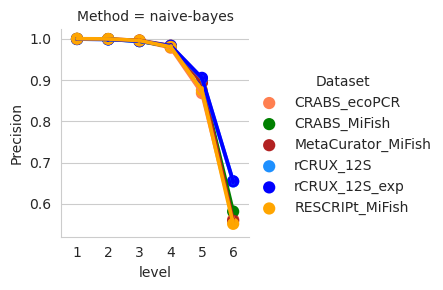

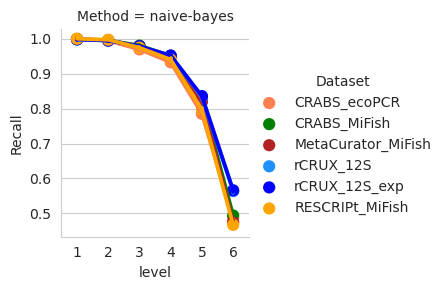

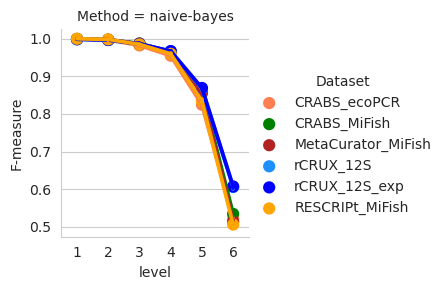

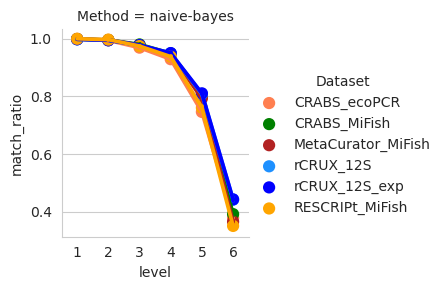

In [68]:
point = pointplot_from_data_frame(level_results, "level", y_vars,
                                  group_by="Method", color_by="Dataset",
                                  color_palette=color_palette)

In [69]:
for k, v in point.items():
    v.savefig(join(outdir, 'cross-val-07-{0}-lineplots.pdf'.format(k)))

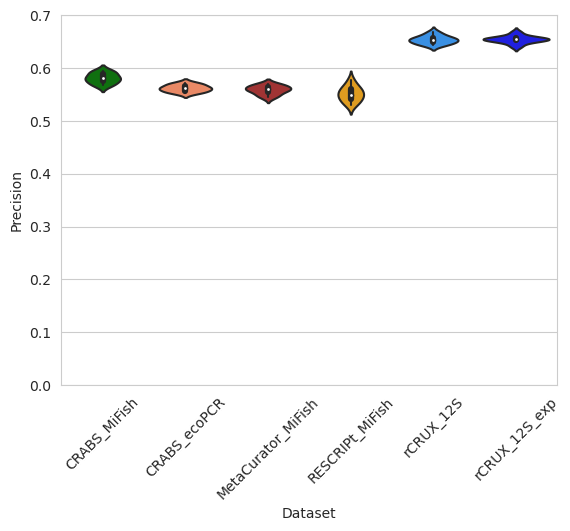

In [20]:
b = boxplot_from_data_frame(level_results[level_results["level"] == 6],group_by="Dataset",
                            metric="Precision",
                            color_palette=color_palette,
                            #y_min= 0,
                            y_max = 0.7
                           )

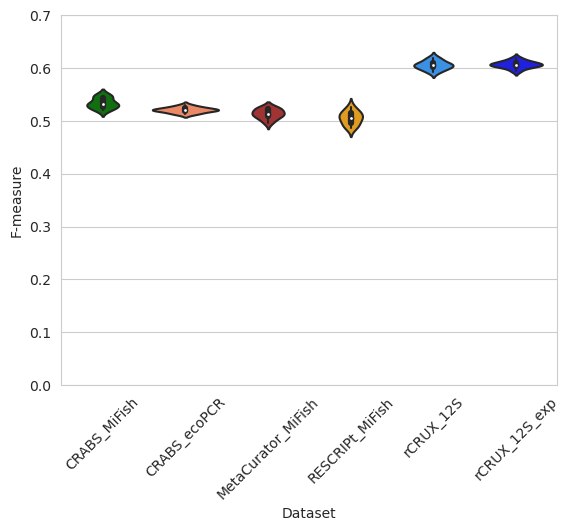

In [21]:
b = boxplot_from_data_frame(level_results[level_results["level"] == 6],group_by="Dataset",
                            metric="F-measure",
                            color_palette=color_palette,
                            #y_min= 0,
                            y_max = 0.7
                           )

#### F-measure, species

In [162]:
from scipy import stats
import statsmodels.stats.multicomp as mc
comp1 = mc.MultiComparison(level_results[level_results["level"] == 6]['F-measure'], level_results[level_results["level"] == 6]['Dataset'])
tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")
tbl

group1,group2,stat,pval,pval_corr,reject
CRABS_MiFish,CRABS_ecoPCR,3.7866,0.0014,0.0203,True
CRABS_MiFish,MetaCurator_MiFish,4.7854,0.0001,0.0022,True
CRABS_MiFish,RESCRIPt_MiFish,5.5791,0.0,0.0004,True
CRABS_MiFish,rCRUX_12S,-17.7882,0.0,0.0,True
CRABS_MiFish,rCRUX_12S_exp,-19.662,0.0,0.0,True
CRABS_ecoPCR,MetaCurator_MiFish,2.1884,0.0421,0.6311,False
CRABS_ecoPCR,RESCRIPt_MiFish,3.5118,0.0025,0.0374,True
CRABS_ecoPCR,rCRUX_12S,-28.1283,0.0,0.0,True
CRABS_ecoPCR,rCRUX_12S_exp,-33.3826,0.0,0.0,True
MetaCurator_MiFish,RESCRIPt_MiFish,1.5732,0.1331,1.0,False


## Taxonomy assignment - novel data, 0.7

In [1]:
from os import system
from os.path import join, expandvars 
import subprocess
from glob import glob
from tax_credit.framework_functions import (recall_novel_taxa_dirs,
                                            parameter_sweep,
                                            move_results_to_repository)

In [2]:
analysis_name= "novel-taxa-simulations"

results_dir = 'novel-taxa-tmp'

In [61]:
iterations = 10
data_dir = join(project_dir, "data", analysis_name)
# databases is a list of names given as dictionary keys in the second
# cell of the database generation notebook. Just list the names here.
databases = ['CRABS_ecoPCR', 'CRABS_MiFish', 'MetaCurator_MiFish', 'rCRUX_12S',
       'rCRUX_12S_exp', 'RESCRIPt_MiFish']

# Generate a list of input directories
(dataset_reference_combinations, reference_dbs) = recall_novel_taxa_dirs(data_dir, databases, iterations,max_level=6, min_level=3)

In [62]:
dataset_reference_combinations[:20]

[('CRABS_ecoPCR-L6-iter0', 'CRABS_ecoPCR-L6-iter0'),
 ('CRABS_ecoPCR-L6-iter1', 'CRABS_ecoPCR-L6-iter1'),
 ('CRABS_ecoPCR-L6-iter2', 'CRABS_ecoPCR-L6-iter2'),
 ('CRABS_ecoPCR-L6-iter3', 'CRABS_ecoPCR-L6-iter3'),
 ('CRABS_ecoPCR-L6-iter4', 'CRABS_ecoPCR-L6-iter4'),
 ('CRABS_ecoPCR-L6-iter5', 'CRABS_ecoPCR-L6-iter5'),
 ('CRABS_ecoPCR-L6-iter6', 'CRABS_ecoPCR-L6-iter6'),
 ('CRABS_ecoPCR-L6-iter7', 'CRABS_ecoPCR-L6-iter7'),
 ('CRABS_ecoPCR-L6-iter8', 'CRABS_ecoPCR-L6-iter8'),
 ('CRABS_ecoPCR-L6-iter9', 'CRABS_ecoPCR-L6-iter9'),
 ('CRABS_ecoPCR-L5-iter0', 'CRABS_ecoPCR-L5-iter0'),
 ('CRABS_ecoPCR-L5-iter1', 'CRABS_ecoPCR-L5-iter1'),
 ('CRABS_ecoPCR-L5-iter2', 'CRABS_ecoPCR-L5-iter2'),
 ('CRABS_ecoPCR-L5-iter3', 'CRABS_ecoPCR-L5-iter3'),
 ('CRABS_ecoPCR-L5-iter4', 'CRABS_ecoPCR-L5-iter4'),
 ('CRABS_ecoPCR-L5-iter5', 'CRABS_ecoPCR-L5-iter5'),
 ('CRABS_ecoPCR-L5-iter6', 'CRABS_ecoPCR-L5-iter6'),
 ('CRABS_ecoPCR-L5-iter7', 'CRABS_ecoPCR-L5-iter7'),
 ('CRABS_ecoPCR-L5-iter8', 'CRABS_ecoPCR-L5-it

#### Prepare method/parameter combinations

Now enter the template of the command to sweep, and generate a list of commands with parameter_sweep().

Fields must adhere to following format:

                  {0} = output directory
                  {1} = input data
                  {2} = output destination
                  {3} = reference taxonomy
                  {4} = method name
                  {5} = other parameters

#### naive-bayes

[fit-classifier-naive-bayes manual](https://docs.qiime2.org/2023.2/plugins/available/feature-classifier/fit-classifier-naive-bayes/)  
- [kmer length setting](https://forum.qiime2.org/t/how-to-set-up-a-high-recall-classifier-change-k-mer-length/5750/13)

[feature-classifier classify-sklearn manual](https://docs.qiime2.org/2023.2/plugins/available/feature-classifier/classify-sklearn/)

In [63]:
method_parameters_combinations = {
    'naive-bayes' : {'p-feat-ext--ngram-range': ['[7,7]'],
                     'p-classify--alpha': [0.001]}
}

command_template = ('mkdir -p "{0}"; '
                    'qiime feature-classifier fit-classifier-naive-bayes --o-classifier '
                    '"{0}/classifier.qza" --i-reference-reads {2} --i-reference-taxonomy {3} {5}; '
                    'qiime feature-classifier classify-sklearn --p-n-jobs 5 '
    '--o-classification "{0}/rep_seqs_tax_assignments.qza" '
    '--i-classifier "{0}/classifier.qza" '
    '--i-reads {1} --p-confidence 0.7; '
    'qiime tools export --input-path "{0}/rep_seqs_tax_assignments.qza" --output-path "{0}/taxonomy.tsv" '
    '--output-format TSVTaxonomyFormat; '
    'mv "{0}/taxonomy.tsv" "{0}/query_tax_assignments.txt"; ')                  

(dataset_reference_combinations, reference_dbs) = recall_novel_taxa_dirs(\
    data_dir, databases, iterations, ref_seqs='ref_seqs.qza',
    ref_taxa='ref_taxa.qza', max_level=6, min_level=3)

        
commands = parameter_sweep(data_dir, results_dir, reference_dbs,
                           dataset_reference_combinations,
                           method_parameters_combinations, command_template,
                           infile='query.qza', output_name='rep_seqs_tax_assignments.qza')

In [64]:
print(len(commands))
print(commands[0])

180
mkdir -p "novel-taxa-tmp/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]"; qiime feature-classifier fit-classifier-naive-bayes --o-classifier "novel-taxa-tmp/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/classifier.qza" --i-reference-reads ./data/novel-taxa-simulations/CRABS_ecoPCR-L6-iter0/ref_seqs.qza --i-reference-taxonomy ./data/novel-taxa-simulations/CRABS_ecoPCR-L6-iter0/ref_taxa.qza --p-classify--alpha 0.001 --p-feat-ext--ngram-range [7,7]; qiime feature-classifier classify-sklearn --p-n-jobs 5 --o-classification "novel-taxa-tmp/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza" --i-classifier "novel-taxa-tmp/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/classifier.qza" --i-reads ./data/novel-taxa-simulations/CRABS_ecoPCR-L6-iter0/query.qza --p-confidence 0.7; qiime tools export --input-path "novel-taxa-tmp/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.0

In [65]:
#testing
subprocess.call(commands[0],shell=True)

Saved TaxonomicClassifier to: novel-taxa-tmp/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/classifier.qza
Saved FeatureData[Taxonomy] to: novel-taxa-tmp/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Exported novel-taxa-tmp/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza as TSVTaxonomyFormat to file novel-taxa-tmp/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/taxonomy.tsv


0

In [30]:
Parallel(n_jobs=5)(delayed(system)(command) for command in commands);

NameError: name 'Parallel' is not defined

### move results over

In [67]:
computed_results_dir = join(project_dir, "data", "self-results", analysis_name)
method_dirs = glob(join(results_dir, '*', '*', '*', '*'))
move_results_to_repository(method_dirs, computed_results_dir)

## Taxonomy assignment - novel data, 0.9

In [37]:
from os import system
from os.path import join, expandvars 
import subprocess
from glob import glob
from tax_credit.framework_functions import (recall_novel_taxa_dirs,
                                            parameter_sweep,
                                            move_results_to_repository)

In [23]:
analysis_name= "novel-taxa-simulations"

results_dir = 'novel-taxa-tmp-09'

In [24]:
iterations = 10
data_dir = join(project_dir, "data", analysis_name)
# databases is a list of names given as dictionary keys in the second
# cell of the database generation notebook. Just list the names here.
databases = ['CRABS_ecoPCR', 'CRABS_MiFish', 'MetaCurator_MiFish', 'rCRUX_12S',
       'rCRUX_12S_exp', 'RESCRIPt_MiFish']

# Generate a list of input directories
(dataset_reference_combinations, reference_dbs) = recall_novel_taxa_dirs(data_dir, databases, iterations,max_level=6, min_level=3)

In [62]:
dataset_reference_combinations[:20]

[('CRABS_ecoPCR-L6-iter0', 'CRABS_ecoPCR-L6-iter0'),
 ('CRABS_ecoPCR-L6-iter1', 'CRABS_ecoPCR-L6-iter1'),
 ('CRABS_ecoPCR-L6-iter2', 'CRABS_ecoPCR-L6-iter2'),
 ('CRABS_ecoPCR-L6-iter3', 'CRABS_ecoPCR-L6-iter3'),
 ('CRABS_ecoPCR-L6-iter4', 'CRABS_ecoPCR-L6-iter4'),
 ('CRABS_ecoPCR-L6-iter5', 'CRABS_ecoPCR-L6-iter5'),
 ('CRABS_ecoPCR-L6-iter6', 'CRABS_ecoPCR-L6-iter6'),
 ('CRABS_ecoPCR-L6-iter7', 'CRABS_ecoPCR-L6-iter7'),
 ('CRABS_ecoPCR-L6-iter8', 'CRABS_ecoPCR-L6-iter8'),
 ('CRABS_ecoPCR-L6-iter9', 'CRABS_ecoPCR-L6-iter9'),
 ('CRABS_ecoPCR-L5-iter0', 'CRABS_ecoPCR-L5-iter0'),
 ('CRABS_ecoPCR-L5-iter1', 'CRABS_ecoPCR-L5-iter1'),
 ('CRABS_ecoPCR-L5-iter2', 'CRABS_ecoPCR-L5-iter2'),
 ('CRABS_ecoPCR-L5-iter3', 'CRABS_ecoPCR-L5-iter3'),
 ('CRABS_ecoPCR-L5-iter4', 'CRABS_ecoPCR-L5-iter4'),
 ('CRABS_ecoPCR-L5-iter5', 'CRABS_ecoPCR-L5-iter5'),
 ('CRABS_ecoPCR-L5-iter6', 'CRABS_ecoPCR-L5-iter6'),
 ('CRABS_ecoPCR-L5-iter7', 'CRABS_ecoPCR-L5-iter7'),
 ('CRABS_ecoPCR-L5-iter8', 'CRABS_ecoPCR-L5-it

#### Prepare method/parameter combinations

Now enter the template of the command to sweep, and generate a list of commands with parameter_sweep().

Fields must adhere to following format:

                  {0} = output directory
                  {1} = input data
                  {2} = output destination
                  {3} = reference taxonomy
                  {4} = method name
                  {5} = other parameters

#### naive-bayes

[fit-classifier-naive-bayes manual](https://docs.qiime2.org/2023.2/plugins/available/feature-classifier/fit-classifier-naive-bayes/)  
- [kmer length setting](https://forum.qiime2.org/t/how-to-set-up-a-high-recall-classifier-change-k-mer-length/5750/13)

[feature-classifier classify-sklearn manual](https://docs.qiime2.org/2023.2/plugins/available/feature-classifier/classify-sklearn/)

In [25]:
method_parameters_combinations = {
    'naive-bayes' : {'p-feat-ext--ngram-range': ['[7,7]'],
                     'p-classify--alpha': [0.001]}
}

command_template = ('mkdir -p "{0}"; '
                    'qiime feature-classifier fit-classifier-naive-bayes --o-classifier '
                    '"{0}/classifier.qza" --i-reference-reads {2} --i-reference-taxonomy {3} {5}; '
                    'qiime feature-classifier classify-sklearn --p-n-jobs 5 '
    '--o-classification "{0}/rep_seqs_tax_assignments.qza" '
    '--i-classifier "{0}/classifier.qza" '
    '--i-reads {1} --p-confidence 0.9; '
    'qiime tools export --input-path "{0}/rep_seqs_tax_assignments.qza" --output-path "{0}/taxonomy.tsv" '
    '--output-format TSVTaxonomyFormat; '
    'mv "{0}/taxonomy.tsv" "{0}/query_tax_assignments.txt"; ')                  

(dataset_reference_combinations, reference_dbs) = recall_novel_taxa_dirs(\
    data_dir, databases, iterations, ref_seqs='ref_seqs.qza',
    ref_taxa='ref_taxa.qza', max_level=6, min_level=3)

        
commands = parameter_sweep(data_dir, results_dir, reference_dbs,
                           dataset_reference_combinations,
                           method_parameters_combinations, command_template,
                           infile='query.qza', output_name='rep_seqs_tax_assignments.qza')

In [26]:
print(len(commands))
print(commands[0])

180
mkdir -p "novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]"; qiime feature-classifier fit-classifier-naive-bayes --o-classifier "novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/classifier.qza" --i-reference-reads ./data/novel-taxa-simulations/CRABS_ecoPCR-L6-iter0/ref_seqs.qza --i-reference-taxonomy ./data/novel-taxa-simulations/CRABS_ecoPCR-L6-iter0/ref_taxa.qza --p-classify--alpha 0.001 --p-feat-ext--ngram-range [7,7]; qiime feature-classifier classify-sklearn --p-n-jobs 5 --o-classification "novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza" --i-classifier "novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/classifier.qza" --i-reads ./data/novel-taxa-simulations/CRABS_ecoPCR-L6-iter0/query.qza --p-confidence 0.9; qiime tools export --input-path "novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/

In [27]:
#testing
subprocess.call(commands[0],shell=True)

Saved TaxonomicClassifier to: novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/classifier.qza
Saved FeatureData[Taxonomy] to: novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Exported novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza as TSVTaxonomyFormat to file novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/taxonomy.tsv


0

In [32]:
Parallel(n_jobs=5)(delayed(system)(command) for command in commands);

Saved TaxonomicClassifier to: novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter2/CRABS_ecoPCR-L6-iter2/naive-bayes/0.001:[7,7]/classifier.qza
Saved TaxonomicClassifier to: novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/classifier.qza
Saved TaxonomicClassifier to: novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter4/CRABS_ecoPCR-L6-iter4/naive-bayes/0.001:[7,7]/classifier.qza
Saved TaxonomicClassifier to: novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter1/CRABS_ecoPCR-L6-iter1/naive-bayes/0.001:[7,7]/classifier.qza
Saved TaxonomicClassifier to: novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter3/CRABS_ecoPCR-L6-iter3/naive-bayes/0.001:[7,7]/classifier.qza
Saved FeatureData[Taxonomy] to: novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter2/CRABS_ecoPCR-L6-iter2/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Saved FeatureData[Taxonomy] to: novel-taxa-tmp-09/CRABS_ecoPCR-L6-iter0/CRABS_ecoPCR-L6-iter0/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Saved FeatureData[Taxonomy] to: novel-taxa-tmp-09/C

### move results over

In [33]:
computed_results_dir = join(project_dir, "data", "self-results-09", analysis_name)
method_dirs = glob(join(results_dir, '*', '*', '*', '*'))
move_results_to_repository(method_dirs, computed_results_dir)

## Evaluate novel taxa results  -c 0.9
Hence, results at each level L represent independent tests, unlike for mock and simulated communities where each level represents the accuracy of each species-level classification trimmed to level L. For novel taxa, results at level L indicate the accuracy with with method M assigns the correct lineage to a "novel" taxon, which is unrepresented in the reference at level L, e.g., level 6 indicates the performance with which each classifier assigns the correct genus to each species.

In [1]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation,
                                            extract_per_level_accuracy)
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset,
                                           boxplot_from_data_frame)

import seaborn as sns
import pandas as pd
from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 200)

In [2]:
%matplotlib inline

In [25]:
project_dir = expandvars("./")
analysis_name = "novel-taxa-simulations"
computed_results_dir = join(project_dir, "data", "self-results-09", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(computed_results_dir, 'evaluate_novel_classification_summary.csv')

results_dirs = glob(join(computed_results_dir, '*', '*', '*', '*'))

# we can save plots in this directory
outdir = expandvars("./plots/")


In [23]:
force = True
if force or not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir, summary_fp)
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

### plot accuracy results 0.9

In [26]:
color_palette={
    'CRABS_ecoPCR': 'coral', 'CRABS_MiFish': 'green',
    'MetaCurator_MiFish': 'firebrick', 'rCRUX_12S': 'dodgerblue',
    'rCRUX_12S_exp': 'blue', 'RESCRIPt_MiFish': 'orange',
}

y_vars = ["Precision", "Recall", "F-measure",
          "overclassification_ratio", 
          "underclassification_ratio", "misclassification_ratio"]

/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incor

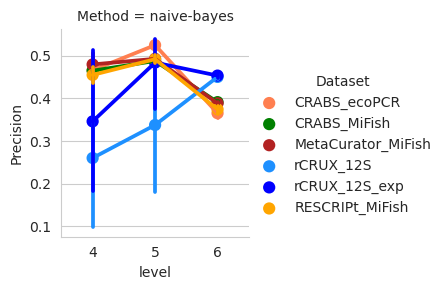

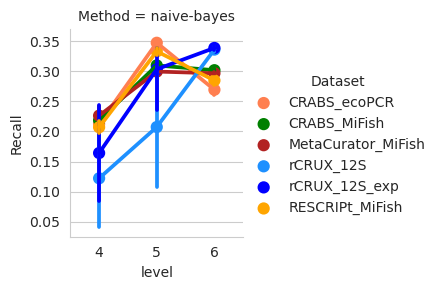

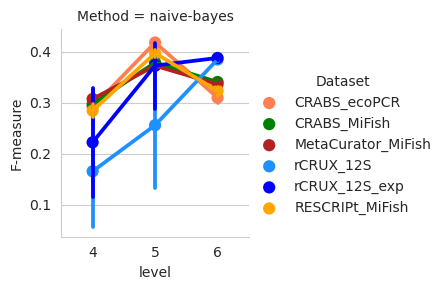

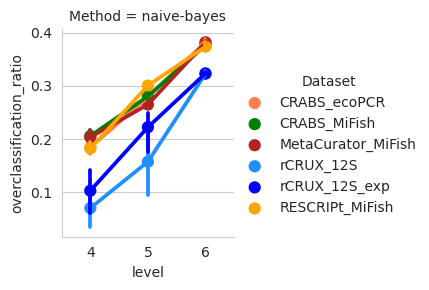

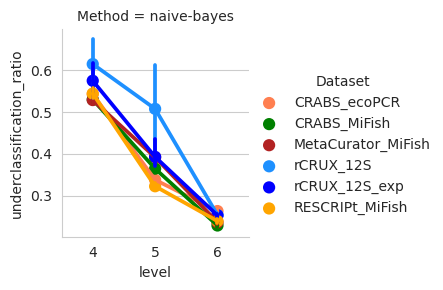

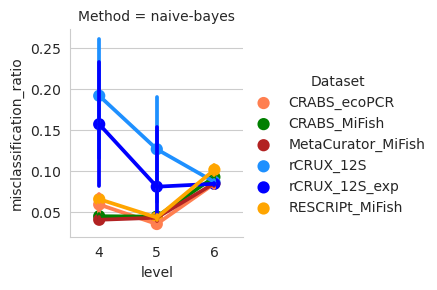

In [27]:
point = pointplot_from_data_frame(accuracy_results, "level", y_vars, 
                                  group_by="Method", color_by="Dataset",
                                  color_palette=color_palette)

In [28]:
for k, v in point.items():
    v.savefig(join(outdir, 'novel-09-{0}-lineplots.pdf'.format(k)))

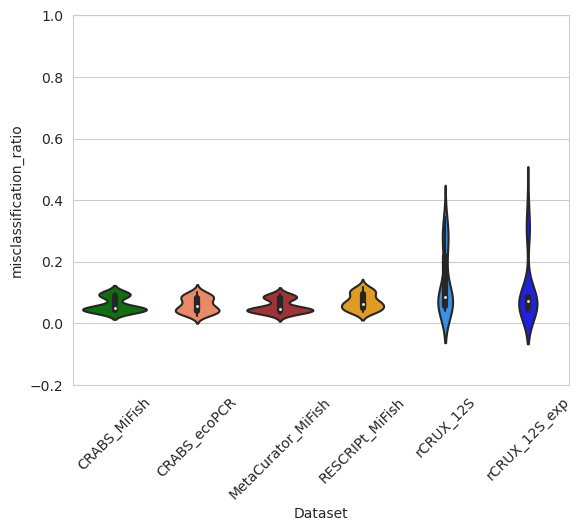

In [29]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="misclassification_ratio",
                            color_palette=color_palette,
                            y_min= -0.2,
                            #y_max = 0.6
                           )

## Evaluate novel taxa results  -c 0.7
Hence, results at each level L represent independent tests, unlike for mock and simulated communities where each level represents the accuracy of each species-level classification trimmed to level L. For novel taxa, results at level L indicate the accuracy with with method M assigns the correct lineage to a "novel" taxon, which is unrepresented in the reference at level L, e.g., level 6 indicates the performance with which each classifier assigns the correct genus to each species.

In [129]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation,
                                            extract_per_level_accuracy)
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset,
                                           boxplot_from_data_frame)

import seaborn as sns
import pandas as pd
from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 200)


In [74]:
%matplotlib inline

In [70]:
project_dir = expandvars("./")
analysis_name = "novel-taxa-simulations"
computed_results_dir = join(project_dir, "data", "self-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(computed_results_dir, 'evaluate_novel_classification_summary.csv')

results_dirs = glob(join(computed_results_dir, '*', '*', '*', '*'))

# we can save plots in this directory
outdir = expandvars("./plots/")


In [72]:
summary_fp

'./data/self-results/novel-taxa-simulations/evaluate_novel_classification_summary.csv'

In [76]:
force = False
if force or not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir, summary_fp)
else:
    accuracy_results = pd.read_csv(summary_fp,index_col=0)

### plot accuracy results

In [77]:
color_palette={
    'CRABS_ecoPCR': 'coral', 'CRABS_MiFish': 'green',
    'MetaCurator_MiFish': 'firebrick', 'rCRUX_12S': 'dodgerblue',
    'rCRUX_12S_exp': 'blue', 'RESCRIPt_MiFish': 'orange',
}

y_vars = ["Precision", "Recall", "F-measure",
          "overclassification_ratio", 
          "underclassification_ratio", "misclassification_ratio"]

/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incor

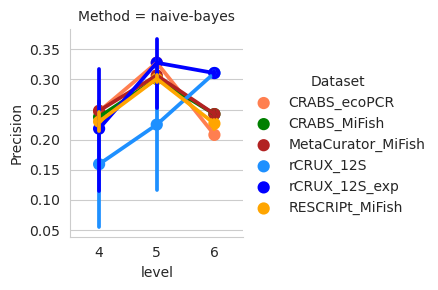

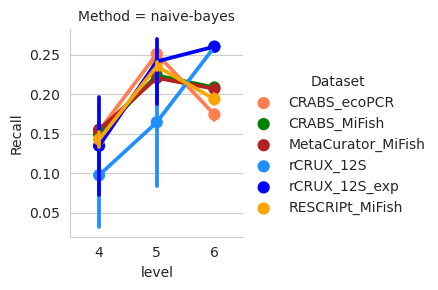

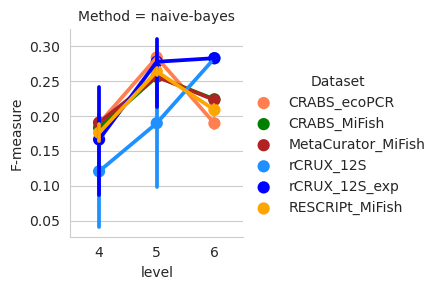

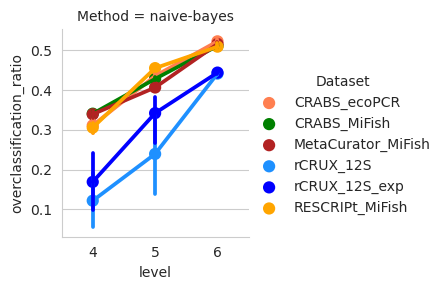

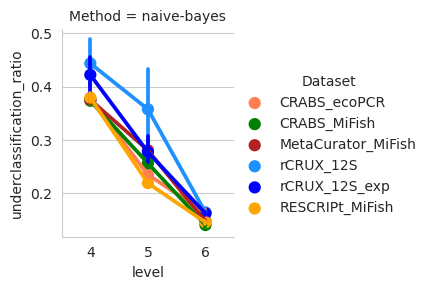

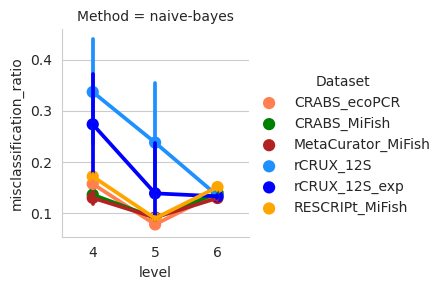

In [33]:
point = pointplot_from_data_frame(accuracy_results, "level", y_vars, 
                                  group_by="Method", color_by="Dataset",
                                  color_palette=color_palette)

In [34]:
for k, v in point.items():
    v.savefig(join(outdir, 'novel-07-{0}-lineplots.pdf'.format(k)))

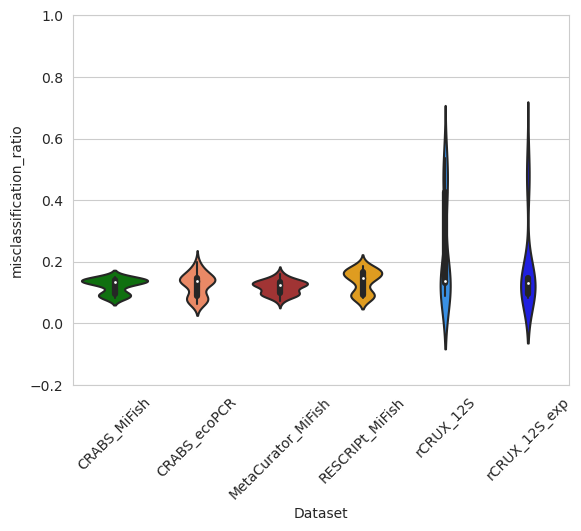

In [78]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="misclassification_ratio",
                            color_palette=color_palette,
                            y_min= -0.2,
                            #y_max = 0.6
                           )

In [79]:
b.figure.savefig(join(outdir, 'novel-07-misclassification_ratio-violinplots.pdf'))

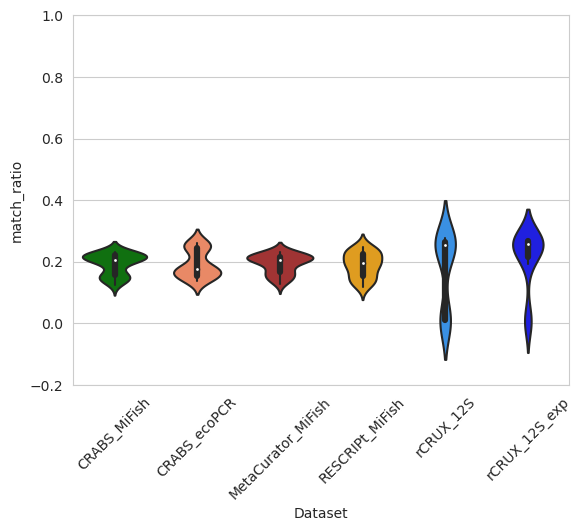

In [80]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="match_ratio",
                            color_palette=color_palette,
                            y_min= -0.2,
                            #y_max = 0.6
                           )

In [81]:
b.figure.savefig(join(outdir, 'novel-07-match_ratio-violinplots.pdf'))

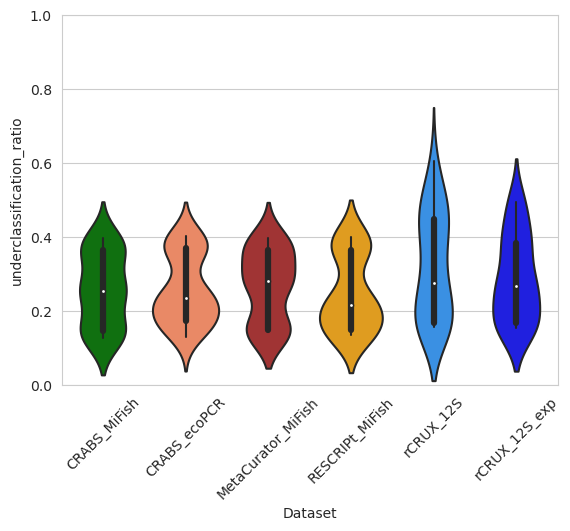

In [83]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="underclassification_ratio",
                            color_palette=color_palette,
                            y_min= 0,
                            #y_max = 0.6
                           )

In [84]:
b.figure.savefig(join(outdir, 'novel-07-underclassification_ratio-violinplots.pdf'))

In [93]:
accuracy_results.to_csv("plots/novel-07-accuracy_results.tsv", sep = "\t")



In [133]:
per_level_kruskal_wallis(accuracy_results,
                             y_vars=['overclassification_ratio',
 'underclassification_ratio',
 'misclassification_ratio','match_ratio','Precision','F-measure'],
                             group_by='Dataset',
                             dataset_col='Method',
                             level_name="level",
                             levelrange=range(4, 7),
                             alpha=0.05,
                             pval_correction='fdr_bh')

,Method,Variable,4,5,6
0,naive-bayes,overclassification_ratio,4.868576e-08,4.437261e-09,7.160320e-08
1,naive-bayes,underclassification_ratio,1.539673e-02,3.084054e-08,2.756787e-07
2,naive-bayes,misclassification_ratio,3.969722e-04,6.362326e-03,3.175270e-05
3,naive-bayes,match_ratio,7.509781e-01,4.776702e-04,4.437261e-09
4,naive-bayes,Precision,7.509781e-01,1.552739e-03,4.437261e-09
5,naive-bayes,F-measure,7.509781e-01,9.880505e-04,4.437261e-09


In [134]:
for var in y_vars:
    dataset_list.append(("naive-bayes", var))
    for level in levelrange:
        level_subset = df1[level_name] == level
        df = {
        for group in df1[group_by].unique():
            group_data = df1[group_by] == group
            group_results = df1[level_subset & group_data][var]
            group_list.append(group_results)

#### F-measure, species

In [156]:
from scipy import stats
import statsmodels.stats.multicomp as mc
comp1 = mc.MultiComparison(accuracy_results[accuracy_results["level"] == 6]['F-measure'], accuracy_results[accuracy_results["level"] == 6]['Dataset'])
tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")
tbl

group1,group2,stat,pval,pval_corr,reject
CRABS_MiFish,CRABS_ecoPCR,8.4505,0.0,0.0,True
CRABS_MiFish,MetaCurator_MiFish,0.2602,0.7976,1.0,False
CRABS_MiFish,RESCRIPt_MiFish,3.4273,0.003,0.0451,True
CRABS_MiFish,rCRUX_12S,-19.6272,0.0,0.0,True
CRABS_MiFish,rCRUX_12S_exp,-18.0631,0.0,0.0,True
CRABS_ecoPCR,MetaCurator_MiFish,-7.5579,0.0,0.0,True
CRABS_ecoPCR,RESCRIPt_MiFish,-3.8573,0.0012,0.0173,True
CRABS_ecoPCR,rCRUX_12S,-24.8323,0.0,0.0,True
CRABS_ecoPCR,rCRUX_12S_exp,-23.5175,0.0,0.0,True
MetaCurator_MiFish,RESCRIPt_MiFish,2.9867,0.0079,0.1187,False


#### F-measure level 5

In [154]:
from scipy import stats
import statsmodels.stats.multicomp as mc
comp1 = mc.MultiComparison(accuracy_results[accuracy_results["level"] == 5]['F-measure'], accuracy_results[accuracy_results["level"] == 5]['Dataset'])
tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")
tbl

group1,group2,stat,pval,pval_corr,reject
CRABS_MiFish,CRABS_ecoPCR,-7.1655,0.0,0.0,True
CRABS_MiFish,MetaCurator_MiFish,0.0186,0.9854,1.0,False
CRABS_MiFish,RESCRIPt_MiFish,-2.1787,0.0429,0.6433,False
CRABS_MiFish,rCRUX_12S,1.3395,0.1971,1.0,False
CRABS_MiFish,rCRUX_12S_exp,-0.6931,0.4971,1.0,False
CRABS_ecoPCR,MetaCurator_MiFish,5.2764,0.0001,0.0008,True
CRABS_ecoPCR,RESCRIPt_MiFish,4.2958,0.0004,0.0065,True
CRABS_ecoPCR,rCRUX_12S,1.8876,0.0753,1.0,False
CRABS_ecoPCR,rCRUX_12S_exp,0.2016,0.8425,1.0,False
MetaCurator_MiFish,RESCRIPt_MiFish,-1.5273,0.1441,1.0,False


#### F-measure level 4

In [155]:
from scipy import stats
import statsmodels.stats.multicomp as mc
comp1 = mc.MultiComparison(accuracy_results[accuracy_results["level"] == 4]['F-measure'], accuracy_results[accuracy_results["level"] == 4]['Dataset'])
tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")
tbl

group1,group2,stat,pval,pval_corr,reject
CRABS_MiFish,CRABS_ecoPCR,-0.8866,0.387,1.0,False
CRABS_MiFish,MetaCurator_MiFish,-0.9879,0.3363,1.0,False
CRABS_MiFish,RESCRIPt_MiFish,0.8784,0.3913,1.0,False
CRABS_MiFish,rCRUX_12S,1.4181,0.1733,1.0,False
CRABS_MiFish,rCRUX_12S_exp,0.3922,0.6995,1.0,False
CRABS_ecoPCR,MetaCurator_MiFish,-0.1845,0.8557,1.0,False
CRABS_ecoPCR,RESCRIPt_MiFish,1.607,0.1254,1.0,False
CRABS_ecoPCR,rCRUX_12S,1.5555,0.1372,1.0,False
CRABS_ecoPCR,rCRUX_12S_exp,0.5343,0.5996,1.0,False
MetaCurator_MiFish,RESCRIPt_MiFish,1.6545,0.1154,1.0,False


## Taxonomic assignment of cross-validated generated data, DB vs DB

**using python to sweep over methods and parameters**

In [74]:
from os import system
import subprocess
from os.path import join, expandvars 
from joblib import Parallel, delayed
from glob import glob
from tax_credit.framework_functions import (recall_novel_taxa_dirs,
                                            parameter_sweep,
                                            move_results_to_repository)

In [43]:
analysis_name= "cross-validated"

results_dir = 'cross-validated-DBVDB-tmp'

#### preparing dataset sweep

First, we're going to define the data sets that we'll sweep over. The "cross-validated" simulated reads that we use here are subsets of reference sequence databases generated duing the novel-taxa analysis. We re-use these data sets here for the purposes of having cross-validated data subsets. As the cross-validated dataset names depend on how the database generation notebook was executed, we must define the variables used to create these datasets. If you modified any variables in that notebook, set these same variables below. If you did not, then do not modify.

recall_novel_taxa_dirs() generates a list of dataset_reference_combinations and a dictionary of reference_dbs mapped to each dataset, which we feed to parameter_sweep below.

In [44]:
iterations = 10
data_dir = join(project_dir, "data", analysis_name)
# databases is a list of names given as dictionary keys in the second
# cell of the database generation notebook. Just list the names here.
databases = ['CRABS_ecoPCR', 'CRABS_MiFish', 'MetaCurator_MiFish', 'rCRUX_12S',
       'rCRUX_12S_exp', 'RESCRIPt_MiFish']

# Generate a list of input directories
(dataset_reference_combinations, reference_dbs) = recall_novel_taxa_dirs(\
    data_dir, databases, iterations, ref_seqs='ref_seqs.qza',
    ref_taxa='ref_taxa.qza', max_level=6, min_level=5, multilevel=False)

In [45]:
dataset_reference_combinations

[('CRABS_ecoPCR-iter0', 'CRABS_ecoPCR-iter0'),
 ('CRABS_ecoPCR-iter1', 'CRABS_ecoPCR-iter1'),
 ('CRABS_ecoPCR-iter2', 'CRABS_ecoPCR-iter2'),
 ('CRABS_ecoPCR-iter3', 'CRABS_ecoPCR-iter3'),
 ('CRABS_ecoPCR-iter4', 'CRABS_ecoPCR-iter4'),
 ('CRABS_ecoPCR-iter5', 'CRABS_ecoPCR-iter5'),
 ('CRABS_ecoPCR-iter6', 'CRABS_ecoPCR-iter6'),
 ('CRABS_ecoPCR-iter7', 'CRABS_ecoPCR-iter7'),
 ('CRABS_ecoPCR-iter8', 'CRABS_ecoPCR-iter8'),
 ('CRABS_ecoPCR-iter9', 'CRABS_ecoPCR-iter9'),
 ('CRABS_MiFish-iter0', 'CRABS_MiFish-iter0'),
 ('CRABS_MiFish-iter1', 'CRABS_MiFish-iter1'),
 ('CRABS_MiFish-iter2', 'CRABS_MiFish-iter2'),
 ('CRABS_MiFish-iter3', 'CRABS_MiFish-iter3'),
 ('CRABS_MiFish-iter4', 'CRABS_MiFish-iter4'),
 ('CRABS_MiFish-iter5', 'CRABS_MiFish-iter5'),
 ('CRABS_MiFish-iter6', 'CRABS_MiFish-iter6'),
 ('CRABS_MiFish-iter7', 'CRABS_MiFish-iter7'),
 ('CRABS_MiFish-iter8', 'CRABS_MiFish-iter8'),
 ('CRABS_MiFish-iter9', 'CRABS_MiFish-iter9'),
 ('MetaCurator_MiFish-iter0', 'MetaCurator_MiFish-iter0'),
 

add other combos to dataset_reference_combinations (dataset, reference)  
testing other DBs against rcrux 

In [59]:
%%bash
# import rcrux DBs to qza
qiime tools import --input-path data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.fasta \
--output-path data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza \
--type 'FeatureData[Sequence]'

qiime tools import --input-path data/ref_dbs/rCRUX_12S/12S_derep_and_clean_taxonomy_clean.tsv \
--output-path data/ref_dbs/rCRUX_12S/12S_derep_and_clean_taxonomy_clean.qza \
--type 'FeatureData[Taxonomy]' --input-format 'TSVTaxonomyFormat'


Imported data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.fasta as DNASequencesDirectoryFormat to data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza
Imported data/ref_dbs/rCRUX_12S/12S_derep_and_clean_taxonomy_clean.tsv as TSVTaxonomyFormat to data/ref_dbs/rCRUX_12S/12S_derep_and_clean_taxonomy_clean.qza


In [69]:
%%bash
#train classifier
qiime feature-classifier fit-classifier-naive-bayes --o-classifier data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza.classifier.qza \
--i-reference-reads data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza \
--i-reference-taxonomy data/ref_dbs/rCRUX_12S/12S_derep_and_clean_taxonomy_clean.qza


Saved TaxonomicClassifier to: data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza.classifier.qza


In [60]:
%%bash
# import rcrux expanded DBs to qza
qiime tools import --input-path data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_clean_MiFishF-MiFishR_trim250.fasta \
--output-path data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza \
--type 'FeatureData[Sequence]'

qiime tools import --input-path data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_taxonomy_clean.tsv \
--output-path data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_taxonomy_clean.qza \
--type 'FeatureData[Taxonomy]' --input-format 'TSVTaxonomyFormat'

Imported data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_clean_MiFishF-MiFishR_trim250.fasta as DNASequencesDirectoryFormat to data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza
Imported data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_taxonomy_clean.tsv as TSVTaxonomyFormat to data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_taxonomy_clean.qza


In [70]:
%%bash
#train classifier
qiime feature-classifier fit-classifier-naive-bayes --o-classifier data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza.classifier.qza \
--i-reference-reads data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza \
--i-reference-taxonomy data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_taxonomy_clean.qza

Saved TaxonomicClassifier to: data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza.classifier.qza


In [62]:
databases_other = ['CRABS_ecoPCR', 'CRABS_MiFish', 'MetaCurator_MiFish', 'RESCRIPt_MiFish']
dataset_reference_combinations = list()
ref1 = 'rCRUX_12S'
ref2 = 'rCRUX_12S_exp'
for database in databases_other:
    for iteration in range(0, 10):
        dataset_name = '{0}-iter{1}'.format(database, iteration)
        dataset_reference_combinations.append((dataset_name, ref1))
        dataset_reference_combinations.append((dataset_name, ref2))

reference_dbs[ref1] = ('./data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza',
                       './data/ref_dbs/rCRUX_12S/12S_derep_and_clean_taxonomy_clean.qza')
reference_dbs[ref2] = ('./data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza',
                       './data/ref_dbs/rCRUX_12S_exp/12S_expanded_derep_and_clean_taxonomy_clean.qza')

In [64]:
dataset_reference_combinations

[('CRABS_ecoPCR-iter0', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter0', 'rCRUX_12S_exp'),
 ('CRABS_ecoPCR-iter1', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter1', 'rCRUX_12S_exp'),
 ('CRABS_ecoPCR-iter2', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter2', 'rCRUX_12S_exp'),
 ('CRABS_ecoPCR-iter3', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter3', 'rCRUX_12S_exp'),
 ('CRABS_ecoPCR-iter4', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter4', 'rCRUX_12S_exp'),
 ('CRABS_ecoPCR-iter5', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter5', 'rCRUX_12S_exp'),
 ('CRABS_ecoPCR-iter6', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter6', 'rCRUX_12S_exp'),
 ('CRABS_ecoPCR-iter7', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter7', 'rCRUX_12S_exp'),
 ('CRABS_ecoPCR-iter8', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter8', 'rCRUX_12S_exp'),
 ('CRABS_ecoPCR-iter9', 'rCRUX_12S'),
 ('CRABS_ecoPCR-iter9', 'rCRUX_12S_exp'),
 ('CRABS_MiFish-iter0', 'rCRUX_12S'),
 ('CRABS_MiFish-iter0', 'rCRUX_12S_exp'),
 ('CRABS_MiFish-iter1', 'rCRUX_12S'),
 ('CRABS_MiFish-iter1', 'rCRUX_12S_exp'),
 ('CRABS_MiFish-iter2', 'rCRUX_12S'),
 (

In [63]:
reference_dbs

{'CRABS_ecoPCR-iter0': ('./data/cross-validated/CRABS_ecoPCR-iter0/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter0/ref_taxa.qza'),
 'CRABS_ecoPCR-iter1': ('./data/cross-validated/CRABS_ecoPCR-iter1/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter1/ref_taxa.qza'),
 'CRABS_ecoPCR-iter2': ('./data/cross-validated/CRABS_ecoPCR-iter2/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter2/ref_taxa.qza'),
 'CRABS_ecoPCR-iter3': ('./data/cross-validated/CRABS_ecoPCR-iter3/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter3/ref_taxa.qza'),
 'CRABS_ecoPCR-iter4': ('./data/cross-validated/CRABS_ecoPCR-iter4/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter4/ref_taxa.qza'),
 'CRABS_ecoPCR-iter5': ('./data/cross-validated/CRABS_ecoPCR-iter5/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter5/ref_taxa.qza'),
 'CRABS_ecoPCR-iter6': ('./data/cross-validated/CRABS_ecoPCR-iter6/ref_seqs.qza',
  './data/cross-validated/CRABS_ecoPCR-iter6/ref_taxa.qza'),

#### Prepare method/parameter combinations

Now enter the template of the command to sweep, and generate a list of commands with parameter_sweep().

Fields must adhere to following format:

                  {0} = output directory
                  {1} = input data
                  {2} = reference seqs
                  {3} = reference taxonomy
                  {4} = method name
                  {5} = other parameters

#### naive-bayes

[fit-classifier-naive-bayes manual](https://docs.qiime2.org/2023.2/plugins/available/feature-classifier/fit-classifier-naive-bayes/)  
- [kmer length setting](https://forum.qiime2.org/t/how-to-set-up-a-high-recall-classifier-change-k-mer-length/5750/13)

[feature-classifier classify-sklearn manual](https://docs.qiime2.org/2023.2/plugins/available/feature-classifier/classify-sklearn/)

In [71]:
method_parameters_combinations = {
    'naive-bayes' : {'p-feat-ext--ngram-range': ['[7,7]'],
                     'p-classify--alpha': [0.001]}
}

command_template = ('mkdir -p "{0}"; '
                    'qiime feature-classifier classify-sklearn --p-n-jobs 5 '
    '--o-classification "{0}/rep_seqs_tax_assignments.qza" '
    '--i-classifier "{2}.classifier.qza" '
    '--i-reads {1} --p-confidence 0.9; '
    'qiime tools export --input-path "{0}/rep_seqs_tax_assignments.qza" --output-path "{0}/taxonomy.tsv" '
    '--output-format TSVTaxonomyFormat; '
    'mv "{0}/taxonomy.tsv" "{0}/query_tax_assignments.txt"; ')                  


commands = parameter_sweep(data_dir, results_dir, reference_dbs,
                           dataset_reference_combinations,
                           method_parameters_combinations, command_template,
                           infile='query.qza', output_name='rep_seqs_tax_assignments.qza')




In [72]:
print(len(commands))
print(commands[0])

80
mkdir -p "cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]"; qiime feature-classifier classify-sklearn --p-n-jobs 5 --o-classification "cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza" --i-classifier "./data/ref_dbs/rCRUX_12S/12S_derep_and_clean_clean_MiFishF-MiFishR_trim250.qza.classifier.qza" --i-reads ./data/cross-validated/CRABS_ecoPCR-iter0/query.qza --p-confidence 0.9; qiime tools export --input-path "cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza" --output-path "cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]/taxonomy.tsv" --output-format TSVTaxonomyFormat; mv "cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]/taxonomy.tsv" "cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]/query_tax_assignments.txt"; 


In [73]:
#testing
subprocess.call(commands[0],shell=True)

Saved FeatureData[Taxonomy] to: cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Exported cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza as TSVTaxonomyFormat to file cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]/taxonomy.tsv


0

In [75]:
Parallel(n_jobs=5)(delayed(system)(command) for command in commands);

Saved FeatureData[Taxonomy] to: cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter1/rCRUX_12S/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Saved FeatureData[Taxonomy] to: cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S_exp/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Saved FeatureData[Taxonomy] to: cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/rCRUX_12S/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Saved FeatureData[Taxonomy] to: cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter2/rCRUX_12S/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Exported cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter1/rCRUX_12S/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza as TSVTaxonomyFormat to file cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter1/rCRUX_12S/naive-bayes/0.001:[7,7]/taxonomy.tsv
Saved FeatureData[Taxonomy] to: cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter1/rCRUX_12S_exp/naive-bayes/0.001:[7,7]/rep_seqs_tax_assignments.qza
Exported cross-validated-DBVDB-tmp/CRABS_ecoPCR-iter0/

## Evaluate cross-validated results, DBvsDB

In [43]:
comp_results_dir

'./data/self-results-dbvdb/cross-validated'

In [38]:
analysis_name= "cross-validated"

results_dir = 'cross-validated-DBVDB-tmp'

comp_results_dir = join(project_dir, "data", "self-results-dbvdb", analysis_name)
method_dirs = glob(join(results_dir, '*', '*', '*', '*'))
move_results_to_repository(method_dirs, comp_results_dir)



In [39]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation,
                                            extract_per_level_accuracy)
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset,
                                           boxplot_from_data_frame)

import seaborn as sns
import pandas as pd
from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 200)

In [40]:
%matplotlib inline

In [41]:
project_dir = expandvars("./")
analysis_name = "cross-validated"
computed_results_dir = join(project_dir, "data", "self-results-dbvdb", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(computed_results_dir, 'evaluate_classification_summary_CV-dbvdb.csv')

results_dirs = glob(join(computed_results_dir, '*', '*', '*', '*'))

# we can save plots in this directory
outdir = expandvars("./plots/")

## not working yet 

Need to edit source code a bit

In [42]:
force = True
if force or not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir,
                                                            summary_fp, test_type='cross-validated')
else:
    accuracy_results = pd.read_csv(summary_fp,index_col=0)

ValueError: not enough values to unpack (expected 2, got 1)

In [29]:
accuracy_results.head()

,Dataset,level,iteration,Method,Parameters,match_ratio,overclassification_ratio,underclassification_ratio,misclassification_ratio,mismatch_level_list,Precision,Recall,F-measure
0,CRABS_ecoPCR,6,0,naive-bayes,"0.001:[7,7]",0.488889,0.275817,0.138562,0.096732,"[0, 1, 8, 45, 58, 290, 556, 572]","[0, 0.9993464052287582, 0.9993429697766097, 0.9952830188679245, 0.9786795048143053, 0.8743608473338204, 0.56752655538695]","[0, 0.9993464052287582, 0.9941176470588236, 0.965359477124183, 0.9300653594771242, 0.7823529411764706, 0.4888888888888889]","[0, 0.9993464052287582, 0.9967234600262124, 0.9800928998009291, 0.9537533512064343, 0.8258020006898931, 0.5252808988764045]"
1,CRABS_ecoPCR,6,1,naive-bayes,"0.001:[7,7]",0.486275,0.275163,0.134641,0.103922,"[0, 0, 6, 39, 58, 281, 574, 572]","[0, 1.0, 0.999344262295082, 0.9973190348525469, 0.9794941900205059, 0.8715925394548063, 0.5619335347432024]","[0, 1.0, 0.996078431372549, 0.9725490196078431, 0.9366013071895425, 0.7941176470588235, 0.48627450980392156]","[0, 1.0, 0.9977086743044191, 0.984778292521509, 0.9575676578683595, 0.8310533515731874, 0.521373510861948]"
2,CRABS_ecoPCR,6,3,naive-bayes,"0.001:[7,7]",0.490850,0.264706,0.130719,0.113725,"[0, 1, 7, 29, 58, 293, 541, 601]","[0, 1.0, 1.0, 0.9959973315543695, 0.9789115646258504, 0.855, 0.5646616541353383]","[0, 0.9993464052287582, 0.9947712418300654, 0.9758169934640523, 0.9405228758169935, 0.7823529411764706, 0.49084967320261436]","[0, 0.9996730957829356, 0.9973787680209699, 0.9858038956751403, 0.9593333333333333, 0.8170648464163823, 0.5251748251748253]"
3,CRABS_ecoPCR,6,2,naive-bayes,"0.001:[7,7]",0.483660,0.285621,0.137255,0.093464,"[0, 0, 11, 45, 67, 250, 576, 581]","[0, 1.0, 0.9980289093298291, 0.9946018893387314, 0.9738292011019284, 0.881159420289855, 0.5606060606060606]","[0, 1.0, 0.9928104575163399, 0.9633986928104575, 0.9241830065359478, 0.7947712418300653, 0.48366013071895425]","[0, 1.0, 0.9954128440366973, 0.9787516600265604, 0.948356807511737, 0.8357388316151202, 0.519298245614035]"
4,CRABS_ecoPCR,6,4,naive-bayes,"0.001:[7,7]",0.488889,0.286928,0.120915,0.103268,"[0, 1, 4, 38, 62, 275, 581, 569]","[0, 0.9993464052287582, 0.9986902423051736, 0.9913333333333333, 0.9721467391304348, 0.8567375886524823, 0.5561338289962825]","[0, 0.9993464052287582, 0.9967320261437909, 0.9718954248366013, 0.9352941176470588, 0.7895424836601307, 0.4888888888888889]","[0, 0.9993464052287582, 0.9977101733725875, 0.9815181518151814, 0.9533644237175217, 0.8217687074829932, 0.5203478260869564]"


### Plot results

Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_palette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).  

**match_ratio** = proportion of correct matches.

**𝐏𝐫𝐞𝐜𝐢𝐬𝐢𝐨𝐧** = true positives /(true positives + false positives  
**𝐑𝐞𝐜𝐚𝐥𝐥** = true positives /(true positives + false negatives)  
**F1**=(2∗ precision ∗ recall)/(precision + recall)  
For precision, a score of 1 indicates only mock community taxa were detected, whereas lower scores indicate detection of additional taxa (e.g., false positives). For recall, a score of 1 indicates all taxa in the mock community were detected, whereas a lower score indicates some taxa were not detected.
The F1 score is the harmonic mean of precision and recall (both measures are weighted equally),

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [47]:
color_palette={
    'CRABS_ecoPCR': 'coral', 'CRABS_MiFish': 'green',
    'MetaCurator_MiFish': 'firebrick', 'rCRUX_12S': 'dodgerblue',
    'rCRUX_12S_exp': 'blue', 'RESCRIPt_MiFish': 'orange',
}

In [48]:
color_palette_method={
    'blast+': 'coral', 'naive-bayes': 'dodgerblue',
    'vsearch': 'firebrick'
}


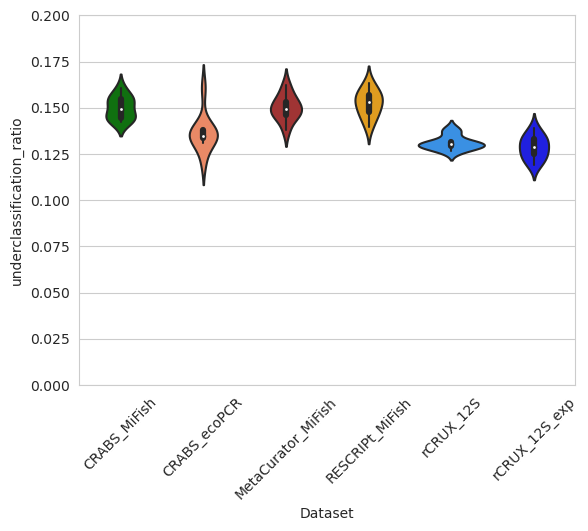

In [49]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="underclassification_ratio",
                            color_palette=color_palette,
                            y_min= 0,
                            y_max = 0.2
                           )

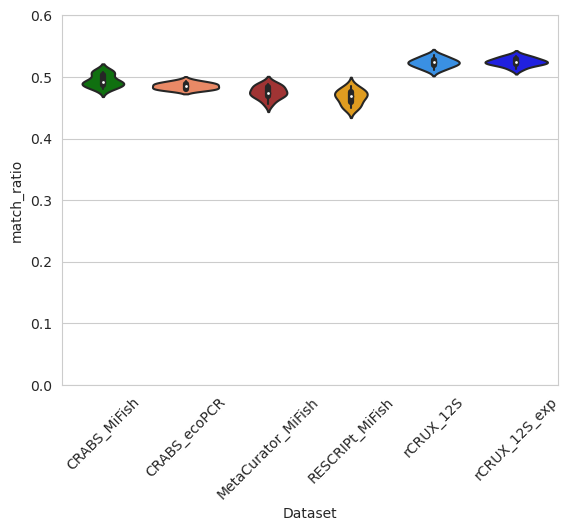

In [50]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="match_ratio",
                            color_palette=color_palette,
                            #y_min= 0,
                            y_max = 0.6
                           )

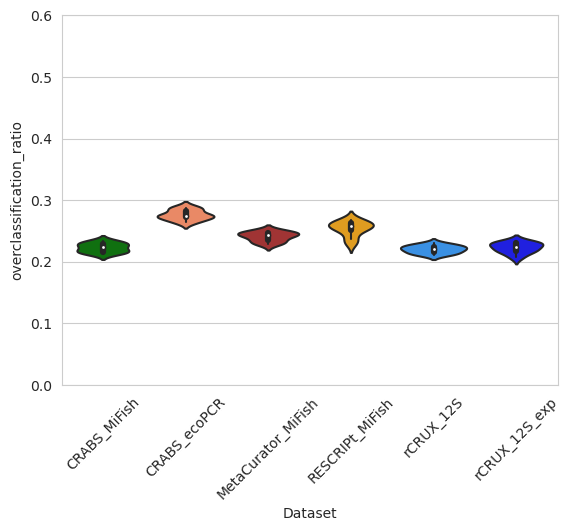

In [52]:
b = boxplot_from_data_frame(accuracy_results,group_by="Dataset",
                            metric="overclassification_ratio",
                            color_palette=color_palette,
                            #y_min= 0,
                            y_max = 0.6
                           )

In [41]:
level_results = extract_per_level_accuracy(accuracy_results)
y_vars = ['Precision', 'Recall', 'F-measure', 'match_ratio']

In [42]:
level_results.head()

,Dataset,level,iteration,Method,Parameters,Precision,Recall,F-measure,match_ratio
0,CRABS_ecoPCR,1,0,naive-bayes,"0.001:[7,7]",0.999346,0.999346,0.999346,0.999346
1,CRABS_ecoPCR,2,0,naive-bayes,"0.001:[7,7]",0.999343,0.994118,0.996723,0.994118
2,CRABS_ecoPCR,3,0,naive-bayes,"0.001:[7,7]",0.995283,0.965359,0.980093,0.964706
3,CRABS_ecoPCR,4,0,naive-bayes,"0.001:[7,7]",0.978680,0.930065,0.953753,0.926797
4,CRABS_ecoPCR,5,0,naive-bayes,"0.001:[7,7]",0.874361,0.782353,0.825802,0.737255


/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/cns.local/katherine.silliman/miniconda3/envs/tax-credit-q2-2023.5/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incor

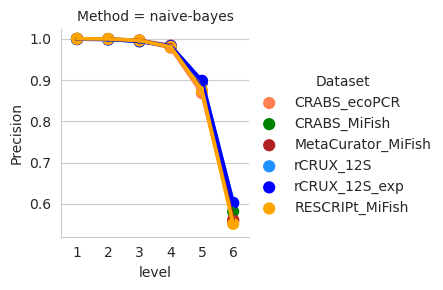

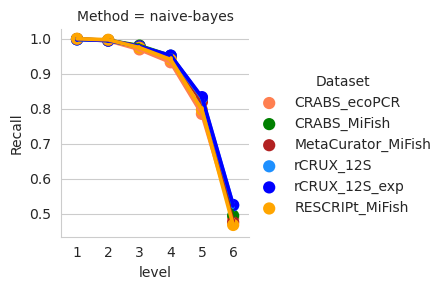

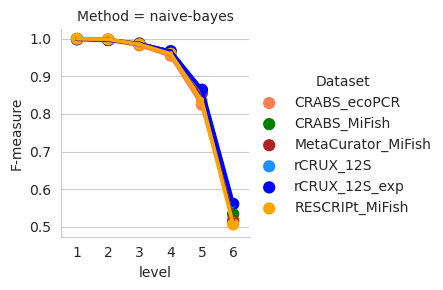

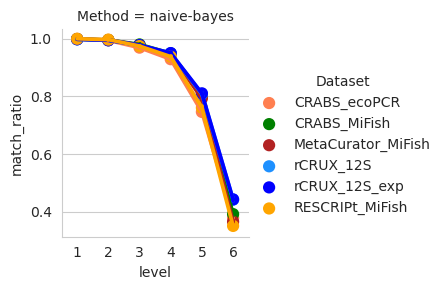

In [53]:
point = pointplot_from_data_frame(level_results, "level", y_vars,
                                  group_by="Method", color_by="Dataset",
                                  color_palette=color_palette)

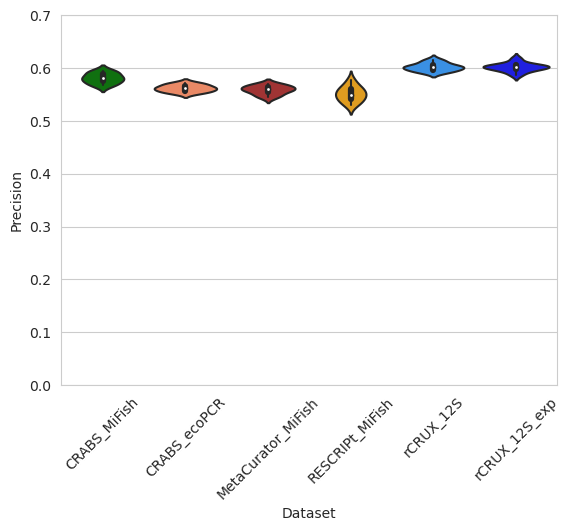

In [57]:
b = boxplot_from_data_frame(level_results[level_results["level"] == 6],group_by="Dataset",
                            metric="Precision",
                            color_palette=color_palette,
                            #y_min= 0,
                            y_max = 0.7
                           )

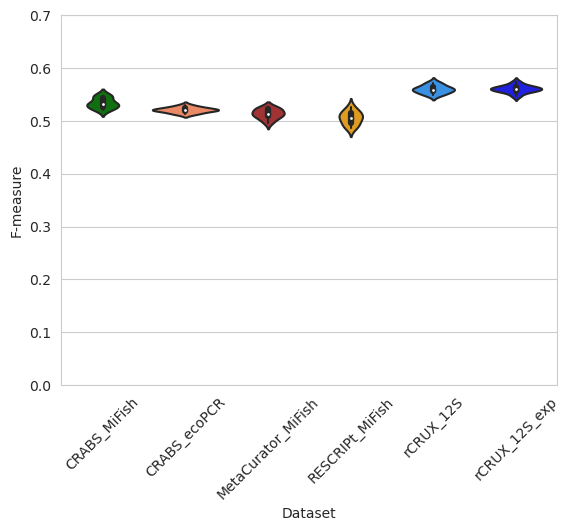

In [58]:
b = boxplot_from_data_frame(level_results[level_results["level"] == 6],group_by="Dataset",
                            metric="F-measure",
                            color_palette=color_palette,
                            #y_min= 0,
                            y_max = 0.7
                           )